# CMIP6 BGWS Plots

### Import Packages

In [2]:
# ========== Packages ==========
import xarray as xr
import pandas as pd
import numpy as np
import os
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
import matplotlib.cm
from matplotlib import rcParams
import math
import multiprocessing as mp
from cftime import DatetimeNoLeap
import glob
import matplotlib.lines as mlines
import sys
from dask.diagnostics import ProgressBar
import importlib
import regionmask

# Define the full path to the data_handling directory and the config file
data_handling_dir = '/work/ch0636/g300115/phd_project/common/src/data_handling'
config_dir = '/work/ch0636/g300115/phd_project/common/src'

# Add the directories to sys.path
sys.path.append(data_handling_dir)
sys.path.append(config_dir)

# Now import the functions from load_preprocessed_data.py and config
import load_data as load_dat
import process_data as pro_dat
import compute_statistics as comp_stats
import save_data_as_nc as sd
from config import BASE_DIR, DEFAULT_MODEL, DEFAULT_VARIABLE, DEFAULT_TEMPORAL_RES, DEFAULT_EXPERIMENT

%matplotlib inline

rcParams["mathtext.default"] = 'regular'

In [24]:
importlib.reload(comp_stats)

<module 'compute_statistics' from '/work/ch0636/g300115/phd_project/common/src/data_handling/compute_statistics.py'>

In [28]:
importlib.reload(pro_dat)

<module 'process_data' from '/work/ch0636/g300115/phd_project/common/src/data_handling/process_data.py'>

### Functions

#### Open files

In [ ]:
# ========= Create a helper function to open the dataset ========
def open_dataset(filename):
    ds = xr.open_dataset(filename)
    return ds

# Define a helper function to open and merge datasets
def open_and_merge_datasets(folder, model, experiment_id, temp_res, variables):
    filepaths = []
    for var in variables:
        path = f'../../data/CMIP6/{experiment_id}/{folder}/{temp_res}/{var}'
        fp = glob.glob(os.path.join(path, f'CMIP.{model}.{experiment_id}.{var}.regridded.nc'))
        if fp:
            filepaths.append(fp[0])
        else:
            print(f"No file found for variable '{var}' in model '{model}'.")
            print(fp)

    datasets = [xr.open_dataset(fp) for fp in filepaths]
    ds = xr.merge(datasets)
    return ds

#### Helper functions

In [ ]:
def drop_var(ds_dict, var):
    for name, ds in ds_dict.items():
        ds_dict[name] = ds.drop(var)
        
    return ds_dict

In [ ]:
def select_period(ds_dict, start_year=None, end_year=None, period=None, yearly_sum=False):
    '''
    Helper function to select periods and optionally compute yearly sums.
    
    Parameters:
    ds_dict (dict): Dictionary with xarray datasets.
    start_year (int): The start year of the period.
    end_year (int): The end year of the period.
    period (int, list, str, None): Single month (int), list of months (list), multiple seasons (str) to select,
                                   or None to not select any specific period.
    yearly_sum (bool): If True, compute the yearly sum over the selected period.
    '''
    
    # Create a deep copy of the original ds_dict to avoid modifying it directly
    ds_dict_copy = copy.deepcopy(ds_dict)

    # Define season to month mapping for northern hemisphere
    seasons_to_months = {
        'nh_winter': [12, 1, 2],
        'nh_spring': [3, 4, 5],
        'nh_summer': [6, 7, 8],
        'nh_fall': [9, 10, 11]
    }
    
    # Define month name mapping
    month_names = {
        1: 'J', 2: 'F', 3: 'M', 4: 'A', 5: 'M', 6: 'J',
        7: 'J', 8: 'A', 9: 'S', 10: 'O', 11: 'N', 12: 'D'
    }

    # Define number of days per month (assuming 28 days for February)
    days_per_month = {
        1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30,
        7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31
    }

    months = []

    # If no specific period is selected, all data will be used.
    if period is None:
        period_name = 'whole_year'
        months = list(range(1, 13))  # All months
    elif isinstance(period, int):
        period_name = month_names[period]
        months = [period]
    elif isinstance(period, str):
        # Check if the input is a single season or multiple seasons
        if 'and' in period:
            seasons = period.lower().split('and')
            period_name = ''
            for season in seasons:
                season = season.strip()
                months.extend(seasons_to_months.get(season, []))
                period_name += ''.join(month_names[m] for m in seasons_to_months.get(season, []))
        else:
            months = seasons_to_months.get(period.lower(), [])
            period_name = ''.join(month_names[m] for m in months)
    elif isinstance(period, list):
        period_name = ''.join(month_names[m] for m in period if m in month_names)
        months = period
    else:
        raise ValueError("Period must be None, an integer, a string representing a single season, "
                         "a string with multiple seasons separated by 'and', or a list of integers.")

    for k, ds in ds_dict_copy.items():
        if start_year and end_year:
            start_date = f'{start_year}-01-01'
            end_date = f'{end_year}-12-31'
            ds = ds.sel(time=slice(start_date, end_date))

        # If months are specified, select those months
        if months:
            month_mask = ds['time.month'].isin(months)
            ds = ds.where(month_mask, drop=True)

        # Store the original attributes of each variable
        original_attrs = {var: ds[var].attrs for var in ds.data_vars}

        # If yearly_sum is True, sum over 'time' dimension to get yearly sum
        if yearly_sum: # does only make sense for accumulative variables e.g. pr or tran
            attrs = ds.attrs
            # Multiply each value by the number of days in the respective month
            days = ds['time'].dt.days_in_month
            ds = (ds * days).resample(time='AS').sum(dim='time')
            sum_type = 'yearly_sum'
            ds.attrs = attrs
        else:
            sum_type = 'monthly_mean'

        # Reassign the original attributes back to each variable
        for var in ds.data_vars:
            ds[var].attrs = original_attrs[var]

        ds_dict_copy[k] = ds
        ds_dict_copy[k].attrs['months'] = period_name
        ds_dict_copy[k].attrs['yearly_sum'] = sum_type

    return ds_dict_copy


In [ ]:
# ======== Standardize ========
def standardize(ds_dict):
    '''
    Helper function to standardize datasets of a dictionary
    '''
    ds_dict_stand = {}
    
    for name, ds in ds_dict.items():
        attrs = ds.attrs
        ds_stand = (ds - ds.mean()) / ds.std()

        # Preserve variable attributes from the original dataset
        for var in ds.variables:
            if var in ds_stand.variables:
                ds_stand[var].attrs = ds[var].attrs

        ds_stand.attrs = attrs
        ds_dict_stand[name] = ds_stand
        
    return ds_dict_stand

In [ ]:
def check_args_and_get_info(ds_dict, variable):
    # Check the validity of input arguments
    if not isinstance(ds_dict, dict):
        raise TypeError("ds_dict must be a dictionary of xarray datasets.")
    if not all(isinstance(ds, xr.Dataset) for ds in ds_dict.values()):
        raise TypeError("All values in ds_dict must be xarray datasets.")
    if not isinstance(variable, str):
        raise TypeError('variable must be a string.')
        
    # Dictionary to store plot titles for each statistic
    titles = {"mean": "Mean", "std": "Standard deviation of yearly means", "min": "Minimum", "max": "Maximum", "median": "Median", "time": "Time", "space": "Space"}
    freq = {"mon": "Monthly"}
    
    long_name = {
        'Precipitation': 'Precipitation',
        'Total Runoff': 'Total Runoff',
        'Vapor Pressure Deficit': 'Vapor Pressure Deficit',
        'Evaporation Including Sublimation and Transpiration': 'Evapotranspiration',
        'Transpiration': 'Transpiration',
        'Leaf Area Index': 'Leaf Area Index',
        'Carbon Mass Flux out of Atmosphere Due to Gross Primary Production on Land [kgC m-2 s-1]': 'Gross Primary Production',
        'Total Liquid Soil Moisture Content of 1 m Column': '1 m Soil Moisture',
        'Total Liquid Soil Moisture Content of 2 m Column': '2 m Soil Moisture',
        'Runoff - Precipitation': 'Runoff - Precipitation',
        'Transpiration - Precipitation': 'Transpiration - Precipitation',
        '(Runoff + Transpiration) - Precipitation':  '(Runoff + Transpiration) - Precipitation',
        'ET - Precipitation':  'ET - Precipitation', 
        'Negative Runoff': 'Negative Runoff',
    }
   
    # Data information
    var_long_name = ds_dict[list(ds_dict.keys())[0]][variable].long_name
    period = f"{ds_dict[list(ds_dict.keys())[0]].attrs['period'][0]}-{ds_dict[list(ds_dict.keys())[0]].attrs['period'][1]}"
    experiment_id =  ds_dict[list(ds_dict.keys())[0]].experiment_id
    unit = ds_dict[list(ds_dict.keys())[0]][variable].units
    statistic_dim = ds_dict[list(ds_dict.keys())[0]].statistic_dimension
    statistic = ds_dict[list(ds_dict.keys())[0]].attrs['statistic']
    frequency = freq[ds_dict[list(ds_dict.keys())[0]].frequency]

    return var_long_name, period, unit, statistic_dim, statistic, experiment_id, titles, frequency

In [ ]:
def compute_ensemble(ds_dict_change):
    for key in ['Ensemble mean', 'Ensemble median']:
        if key in ds_dict_change:
            ds_dict_change.pop(key)

    # Drop 'member_id' coordinate if it exists in any of the datasets
    for ds_key in ds_dict_change:
        if 'member_id' in ds_dict_change[ds_key].coords:
            ds_dict_change[ds_key] = ds_dict_change[ds_key].drop('member_id')

    combined = xr.concat(ds_dict_change.values(), dim='ensemble')
    ds_dict_change['Ensemble median'] = getattr(combined, 'median')(dim='ensemble')
    
    return ds_dict_change

In [ ]:
import regionmask

def apply_region_mask(ds_dict):
    """
    Applies the AR6 land region mask to datasets in the provided dictionary and adds a region dimension.

    Args:
        ds_dict (dict): A dictionary of xarray datasets.

    Returns:
        dict: A new dictionary where keys are the same as in the input dictionary,
              and each value is an xarray Dataset with a region dimension added to each variable.
    """
    
    land_regions = regionmask.defined_regions.ar6.land
    ds_masked_dict = {}
    
    for ds_name, ds in ds_dict.items():
        ds_out = xr.Dataset()  # Initiate an empty Dataset for the masked data
        
        # Get attributes
        attrs = ds.attrs
        
        for var in ds:
            # Get the binary mask
            mask = land_regions.mask_3D(ds[var])
            
            var_attrs = ds[var].attrs

            # Multiply the original data with the mask to get the masked data
            masked_var = ds[var] * mask

            # Replace 0s with NaNs, if desired
            masked_var = masked_var.where(masked_var != 0)

            # Add the masked variable to the output Dataset
            ds_out[var] = masked_var
            
            ds_out[var].attrs = var_attrs
            
        # Add the attributes
        ds_out.attrs = attrs

        # Add the Dataset to the output dictionary
        ds_masked_dict[ds_name] = ds_out

    return ds_masked_dict

In [ ]:
def is_numeric(data):
    try:
        _ = data.astype(float)
        return True
    except (ValueError, TypeError):
        return False

def compute_change(ds_dict_hist, ds_dict_fut, var_rel_change=None):
    ds_dict_change = {}

    for name, ds_hist in ds_dict_hist.items():
        if name in ds_dict_fut:
            ds_future = ds_dict_fut[name]
            common_vars = set(ds_hist.data_vars).intersection(ds_future.data_vars)

            ds_change = ds_hist.copy(deep=True)
            
            if var_rel_change == 'all':
                var_rel_change = common_vars
                
            for var in common_vars:
                if is_numeric(ds_hist[var].data) and is_numeric(ds_future[var].data):
                    if var_rel_change is not None and var in var_rel_change:
                        # Compute relative change where ds_hist is not zero
                        rel_change = (ds_future[var] - ds_hist[var]) / ds_hist[var].where(ds_hist[var] != 0) * 100
                        ds_change[var].data = rel_change.data
                        ds_change[var].attrs['units'] = '%'
                    else:
                        # Compute absolute change
                        abs_change = ds_future[var] - ds_hist[var]
                        ds_change[var].data = abs_change.data

            ds_change.attrs = ds_future.attrs
            ds_dict_change[name] = ds_change

    return ds_dict_change

#### Compute statistics

In [ ]:
def calculate_spatial_mean(ds_dict):
    ds_dict_mean = {}
    for key, ds in ds_dict.items():
        attrs = ds.attrs
        for var in list(ds.data_vars.keys()):
            var_attrs = ds[var].attrs
            
            ds_dict_mean[key][var] = ds.mean(['lon', 'lat'])
            ds_dict_mean[key][var].attrs = var_attrs
        
        ds_dict_mean[key].attrs = attrs
        
    return ds_dict_mean

In [ ]:
def compute_statistic_single(ds, statistic, dimension, yearly_mean=True):
    if dimension == "time":
        stat_ds = getattr(ds, statistic)("time", keep_attrs=True, skipna=True)
        stat_ds.attrs['period'] = [str(ds.time.dt.year[0].values), str(ds.time.dt.year[-1].values)]
        
    if dimension == "space":
        # Assign the period attribute before grouping by year
        ds.attrs['period'] = [str(ds.time.dt.year[0].values), str(ds.time.dt.year[-1].values)]
        
        if yearly_mean:
            ds = ds.groupby('time.year').mean('time', keep_attrs=True, skipna=True)
            ds.attrs['mean'] = 'yearly mean'
            
        
        #get the weights, apply on data, and compute statistic
        weights = np.cos(np.deg2rad(ds.lat))
        weights.name = "weights"
        ds_weighted = ds.weighted(weights)
        stat_ds = getattr(ds_weighted, statistic)(("lon", "lat"), keep_attrs=True, skipna=True)
    
    stat_ds.attrs['statistic'] = statistic
    stat_ds.attrs['statistic_dimension'] = dimension

    return stat_ds

In [ ]:
def compute_statistic(ds_dict, statistic, dimension, start_year=None, end_year=None, yearly_mean=True):
    """
    Computes the specified statistic for each dataset in the dictionary.

    Args:
        ds_dict (dict): A dictionary of xarray datasets, where each key is the name of the dataset
            and each value is the dataset itself.
        statistic (str): The statistic to compute, which can be one of 'mean', 'std', 'min', 'var', or 'median'.
        dimension (str): The dimension to compute over, which can be 'time' or 'space'.
        start_year (str, optional): The start year of the period to compute the statistic over.
        end_year (str, optional): The end year of the period to compute the statistic over.

    Returns:
        dict: A dictionary with computed statistic for each dataset.
    """
    # Check the validity of input arguments
    if not isinstance(ds_dict, dict):
        raise TypeError("ds_dict must be a dictionary of xarray datasets.")
    if not all(isinstance(ds, xr.Dataset) for ds in ds_dict.values()):
        raise TypeError("All values in ds_dict must be xarray datasets.")
    if statistic not in ["mean", "std", "min", "max", "var", "median"]:
        raise ValueError(f"Invalid statistic '{statistic}' specified.")
    if dimension not in ["time", "space"]:
        raise ValueError(f"Invalid dimension '{dimension}' specified.")

    # Select period
    if start_year is not None and end_year is not None:
        select_period(ds_dict, start_year=start_year, end_year=end_year)
        
        
    # Use multiprocessing to compute the statistic for each dataset in parallel
    with mp.Pool() as pool:
        results = pool.starmap(compute_statistic_single, [(ds, statistic, dimension, yearly_mean) for ds in ds_dict.values()])

    return dict(zip(ds_dict.keys(), results))

In [ ]:
from itertools import permutations

def precompute_metrics(ds_dict, variables, metrics=['pearson']):
    # Initialize the results dictionary
    results_dict = {metric: {} for metric in metrics}
    
    for name, ds in ds_dict.items():
        # Create a DataFrame with all the variables
        df = pd.DataFrame({var: ds[var].values.flatten() for var in variables})
        
        # Define all pairs of variables
        pairs = list(permutations(variables, 2))  # <-- Change here
        args = [(df, var1, var2, metrics) for var1, var2 in pairs]

        # Use a multiprocessing pool to compute the metrics for all pairs
        with Pool() as p:
            results = p.map(compute_metrics_for_pair, args)
        
        # Store the results in the results_dict
        for var1, var2, metric_dict in results:
            for metric, value in metric_dict.items():
                # Ensure the keys exist in the dictionary
                results_dict[metric].setdefault(name, {}).setdefault(f'{var1}_{var2}', value)
    return results_dict

In [ ]:
def compute_stats(ds_dict):
    """
    Compute yearly mean of each variable in the dataset.

    Parameters:
    ds_dict (dict): The input dictionary of xarray.Dataset.

    Returns:
    dict: A dictionary where the keys are the dataset names and the values are another dictionary.
          This inner dictionary has keys as variable names and values as DataArray of yearly means.
    """
    stats = {}
    for model, ds in ds_dict.items():
        # Compute the yearly mean
        yearly_ds = ds.resample(time='1Y').mean()

        stats[model] = {}
        for var in yearly_ds.data_vars:
            # Compute the spatial mean
            spatial_mean = yearly_ds[var].mean(dim=['lat', 'lon'])
            
            # Store the yearly mean values
            stats[model][var] = spatial_mean
    return stats

In [ ]:
def compute_yearly_means(ds_dict):
    yearly_means_dict = {}

    # For each dataset, compute the yearly mean over the 'time', 'lat', and 'lon' dimensions
    for name, ds in ds_dict.items():  
        ds_yearly = ds.groupby('time.year').mean('time')    
        
        yearly_means_dict[name] = ds_yearly

    return yearly_means_dict

In [ ]:
def compute_yearly_regional_means(ds_dict_region):
    yearly_means_dict = {}

    # For each dataset, compute the yearly mean over the 'time', 'lat', and 'lon' dimensions
    for region, ds_dict in ds_dict_region.items():
        yearly_means_dict[region] = {}
        for ds_name, ds in ds_dict.items():
            # Compute the yearly mean
            ds_yearly = ds.groupby('time.year').mean('time')
            
            # Create weights
            weights = np.cos(np.deg2rad(ds.lat))
            # Apply the weights and calculate the spatial mean
            ds_weighted = ds_yearly.weighted(weights)
            yearly_means_dict[region][ds_name] = ds_weighted.mean(('lat', 'lon'))

    return yearly_means_dict

In [ ]:
def calculate_spatial_mean(ds_dict):
    ds_dict_mean = {}
    
    for key, ds in ds_dict.items():
        attrs = ds.attrs
        
        # Initialize a new Dataset for this key
        ds_dict_mean[key] = xr.Dataset()
        
        for var in list(ds.data_vars.keys()):
            var_attrs = ds[var].attrs
            
            ds_dict_mean[key][var] = ds[var].mean(['lon', 'lat'])
            ds_dict_mean[key][var].attrs = var_attrs
        
        ds_dict_mean[key].attrs = attrs
        
    return ds_dict_mean

In [ ]:
def calculate_spatial_mean_std(ds_dict):
    ds_stats = {}
    
    for key, ds in ds_dict.items():
        attrs = ds.attrs
        
        # Initialize a new Dataset for spatial statistics
        ds_stats[key] = xr.Dataset()
        
        for var in list(ds.data_vars.keys()):
            var_attrs = ds[var].attrs
            
            # Calculate the mean and standard deviation, skipping NaN values
            ds_stats[key][f'{var}'] = ds[var].mean(['lon', 'lat'], skipna=True)
            ds_stats[key][f'{var}'].attrs = var_attrs
            
            # Use a minimum count of 2 for standard deviation to ensure degrees of freedom > 0
            ds_stats[key][f'{var}_std'] = ds[var].std(['lon', 'lat'], skipna=True)
            ds_stats[key][f'{var}_std'].attrs = var_attrs
        
        ds_stats[key].attrs = attrs
        
    return ds_stats

In [ ]:
def compute_bgws(ds_dict):

    for model, ds in ds_dict.items():
        bgws = (ds['mrro']-ds['tran'])/ds['pr'] * 100

        # Replace infinite values with NaN
        bgws = xr.where(np.isinf(bgws), float('nan'), bgws)

        # Set all values above 2 and below -2 to NaN
        bgws = xr.where(bgws > 200, float('nan'), bgws)
        bgws = xr.where(bgws < -200, float('nan'), bgws)

        ds_dict[model]['bgws'] = bgws
        ds_dict[model]['bgws'].attrs = {'long_name': 'Blue Green Water Share',
                             'units': ''}
        
    return ds_dict

## 1. Load and Preprocess

In [3]:
# ========= Define period, models and path ==============
data_state = 'processed'
data_product = 'CMIP6'
experiments = ['historical', 'ssp370']
models = ['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CNRM-ESM2-1', 'GISS-E2-1-G', 'MIROC-ES2L', 'NorESM2-MM', 'UKESM1-0-LL', 'CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'MPI-ESM1-2-LR', 'TaiESM1']
variables=['pr', 'tran', 'mrro'] 
           
# Execute load function with Dask
with ProgressBar():
    ds_dict = dask.compute(load_dat.load_period_mean(BASE_DIR, data_state, data_product, experiments, models, variables, specific_months_or_seasons=None))[0]

Loading 'month' resolution variables ['pr', 'tran', 'mrro'] for experiment 'historical'...
Selecting period 1985-2014 for 'month' variables in experiment 'historical'...
Computing period mean for 'month' variables in experiment 'historical'...
Merging all datasets for experiment 'historical'...
Loading 'month' resolution variables ['pr', 'tran', 'mrro'] for experiment 'ssp370'...
Selecting period 2071-2100 for 'month' variables in experiment 'ssp370'...
Computing period mean for 'month' variables in experiment 'ssp370'...
Merging all datasets for experiment 'ssp370'...
[########################################] | 100% Completed | 11.69 s


In [4]:
ds_dict['historical'].keys()

dict_keys(['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CNRM-ESM2-1', 'GISS-E2-1-G', 'MIROC-ES2L', 'NorESM2-MM', 'UKESM1-0-LL', 'CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'MPI-ESM1-2-LR', 'TaiESM1'])

## 2. Compute Historical BGWS and Ensemble statsitics

In [29]:
ds_dict = pro_dat.compute_bgws(ds_dict)

Ignored ensemble data for historical - Ensemble median
Ignored ensemble data for historical - Ensemble mean
Ignored ensemble data for ssp370 - Ensemble median


In [31]:
ds_dict['historical'] = comp_stats.compute_ensemble_statistic(ds_dict['historical'], 'mean')
ds_dict['historical'] = comp_stats.compute_ensemble_statistic(ds_dict['historical'], 'median')

Computed Ensemble mean for all experiments.
Computed Ensemble median for all experiments.


In [32]:
ds_dict['ssp370'] = comp_stats.compute_ensemble_statistic(ds_dict['ssp370'], 'mean')
ds_dict['ssp370'] = comp_stats.compute_ensemble_statistic(ds_dict['ssp370'], 'median')

Computed Ensemble mean for all experiments.
Computed Ensemble median for all experiments.


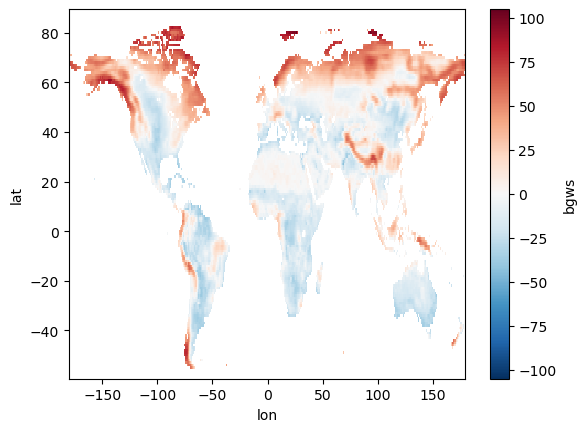

In [33]:
ds_dict['historical']['Ensemble mean'].bgws.plot()

## 3. Compute Changes and Ensemble statsitics

In [ ]:
ds_dict_change = lap.compute_change_dict(ds_dict)

In [ ]:
ds_dict_change['ssp370-historical'].keys()

In [ ]:
ds_dict_change['ssp370-historical'] = lap.compute_ensemble(ds_dict_change['ssp370-historical'], 'mean')
ds_dict_change['ssp370-historical'] = lap.compute_ensemble(ds_dict_change['ssp370-historical'], 'median')

## 4. Subdivide Regions and Compute Regional Means

In [ ]:
ds_dict_regions = lap.subdivide_region_and_compute_mean(ds_dict, with_global=True, spatial_mean=True)

In [ ]:
ds_dict_regions_mean = lap.subdivide_region_and_compute_mean(ds_dict, with_global=True, spatial_mean=True)

In [ ]:
ds_dict_regions_change = lap.compute_change_dict(ds_dict_regions)

In [ ]:
ds_dict_regions_change['historical-ssp370'] = lap.compute_ensemble(ds_dict_regions_change['historical-ssp370'], 'mean')
ds_dict_regions_change['historical-ssp370'] = lap.compute_ensemble(ds_dict_regions_change['historical-ssp370'], 'median')

In [ ]:
ds_dict_regions_change['historical-ssp370']['Ensemble mean']

### Test Models with prognostic vegetation against non-prgnostic vegetation models

In [ ]:
# List of models with prognostic vegetation
models_prog_veg = [
    'UKESM1-0-LL', 
    'MPI-ESM1-2-LR', 
    'GFDL-ESM4'
]

# Create new dictionaries to store models with and without prognostic vegetation
ds_dict_prog_veg = {'historical': {}, 'ssp370': {}}
ds_dict_no_prog_veg = {'historical': {}, 'ssp370': {}}

# Iterate through the original dictionary and classify models
for scenario in ds_dict:
    for model in ds_dict[scenario]:
        # Exclude 'Ensemble mean' and 'Ensemble median'
        if model in ['Ensemble mean', 'Ensemble median']:
            continue
        if model in models_prog_veg:
            ds_dict_prog_veg[scenario][model] = ds_dict[scenario][model]
        else:
            ds_dict_no_prog_veg[scenario][model] = ds_dict[scenario][model]

ds_dict_prog_veg['historical'] = lap.compute_ensemble(ds_dict_prog_veg['historical'], 'mean')
ds_dict_prog_veg['historical'] = lap.compute_ensemble(ds_dict_prog_veg['historical'], 'median')
ds_dict_no_prog_veg['historical'] = lap.compute_ensemble(ds_dict_no_prog_veg['historical'], 'mean')
ds_dict_no_prog_veg['historical'] = lap.compute_ensemble(ds_dict_no_prog_veg['historical'], 'median')

In [ ]:
# Create new dictionaries to store models with and without prognostic vegetation
ds_dict_regions_change_prog_veg = {'historical-ssp370': {}}
ds_dict_regions_change_no_prog_veg = {'historical-ssp370': {}}

# Iterate through the original dictionary and classify models
for scenario in ds_dict_regions_change:
    for model in ds_dict_regions_change[scenario]:
        # Exclude 'Ensemble mean' and 'Ensemble median'
        if model in ['Ensemble mean', 'Ensemble median']:
            continue
        if model in models_prog_veg:
            ds_dict_regions_change_prog_veg[scenario][model] = ds_dict_regions_change[scenario][model]
        else:
            ds_dict_regions_change_no_prog_veg[scenario][model] = ds_dict_regions_change[scenario][model]


ds_dict_regions_change_prog_veg['historical-ssp370'] = lap.compute_ensemble(ds_dict_regions_change_prog_veg['historical-ssp370'], 'mean')
ds_dict_regions_change_prog_veg['historical-ssp370'] = lap.compute_ensemble(ds_dict_regions_change_prog_veg['historical-ssp370'], 'median')
ds_dict_regions_change_no_prog_veg['historical-ssp370'] = lap.compute_ensemble(ds_dict_regions_change_no_prog_veg['historical-ssp370'], 'mean')
ds_dict_regions_change_no_prog_veg['historical-ssp370'] = lap.compute_ensemble(ds_dict_regions_change_no_prog_veg['historical-ssp370'], 'median')

## 4. Plot BGWS

### Create colormaps

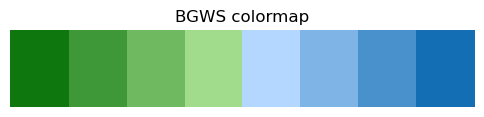

In [34]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import BoundaryNorm

# Define start and end colors for both gradients
deep_blue = (20/255, 110/255, 180/255)  
light_blue = (180/255, 215/255, 255/255)
deep_green = (14/255, 119/255, 14/255) 
light_green = (160/255, 220/255, 140/255)

# Create custom colormaps
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", [light_blue, deep_blue], N=4)
green_cmap = LinearSegmentedColormap.from_list("green_cmap", [deep_green, light_green], N=4)

# Sample colors from colormaps
blue_colors = [blue_cmap(i) for i in np.linspace(0, 1, 4)]
green_colors = [green_cmap(i) for i in np.linspace(0, 1, 4)]

# Combine both gradients
combined_grad = green_colors + blue_colors 

# Define boundaries
boundaries = [-0.1, -0.75, -0.05, -0.25, 0, 0.25, 0.05, 0.75, 0.1]
norm = BoundaryNorm(boundaries, len(combined_grad), clip=True)

cmap_name = 'BGWS colormap'
bgws_cm = LinearSegmentedColormap.from_list(cmap_name, combined_grad, N=len(combined_grad))

# To test and display the colormap
fig, ax = plt.subplots(figsize=(6, 1))
ax.set_title(cmap_name)
plt.imshow(np.linspace(0, 1, 256).reshape(1, -1), aspect='auto', cmap=bgws_cm)
plt.axis('off')
plt.show()

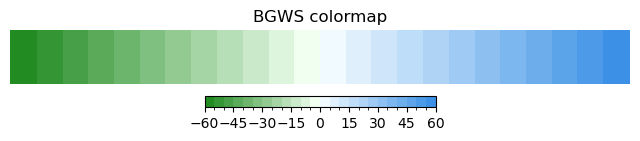

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

# Define start and end colors for both gradients
deep_blue = (60/255, 145/255, 230/255)
light_blue = (240/255, 250/255, 255/255)  # Brighter pastel light blue
deep_green = (34/255, 139/255, 34/255)
light_green = (240/255, 255/255, 240/255)  

# Create custom colormaps for the blue and green gradients
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", [light_blue, deep_blue], N=12)
green_cmap = LinearSegmentedColormap.from_list("green_cmap", [deep_green, light_green], N=12)

# Sample colors from the colormaps
blue_colors = [blue_cmap(i) for i in np.linspace(0, 1, 12)]
green_colors = [green_cmap(i) for i in np.linspace(0, 1, 12)]

# Combine both gradients with white in the middle
combined_grad = green_colors + blue_colors

# Define boundaries for the bins from -60 to 60 in steps of 10
boundaries = np.arange(-60, 65, 5)

# Create a binned colormap using BoundaryNorm
norm = BoundaryNorm(boundaries, ncolors=len(combined_grad), clip=True)

# Create the combined colormap
cmap_name = 'BGWS colormap'
bgws_cm = LinearSegmentedColormap.from_list(cmap_name, combined_grad, N=len(combined_grad))

# To test and display the colormap
fig, ax = plt.subplots(figsize=(8, 1))
ax.set_title(cmap_name)
plt.imshow(np.linspace(-60, 60, 256).reshape(1, -1), aspect='auto', cmap=bgws_cm, norm=norm)
plt.colorbar(plt.cm.ScalarMappable(cmap=bgws_cm, norm=norm), ax=ax, orientation='horizontal')
plt.axis('off')
plt.show()

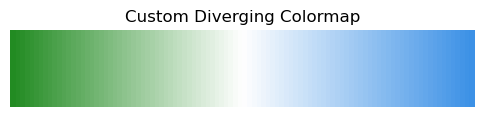

In [64]:
from matplotlib.colors import LinearSegmentedColormap

colors = [(34/255, 139/255, 34/255), (1, 1, 1), (60/255, 145/255, 230/255)]  # Green -> White -> Blue
n_bins = [3]  # Discretizes the interpolation into bins
cmap_name = 'custom_div_cmap'

cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

# To test and display the colormap
fig, ax = plt.subplots(figsize=(6, 1))
ax.set_title('Custom Diverging Colormap')
plt.imshow(np.linspace(0, 1, 256).reshape(1, -1), aspect='auto', cmap=cm)
plt.axis('off')
plt.show()

In [ ]:
colors = ['darkgoldenrod', (1, 1, 1), 'blueviolet']  
n_bins = [3]  # Discretizes the interpolation into bins
cmap_name = 'custom_div_cmap'

cm_change = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

# To test and display the colormap
fig, ax = plt.subplots(figsize=(6, 1))
ax.set_title('Custom Diverging Colormap')
plt.imshow(np.linspace(0, 1, 256).reshape(1, -1), aspect='auto', cmap=cm_change)
plt.axis('off')
plt.show()

In [ ]:
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import regionmask
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

### Plot Global BGWS with statistics

In [74]:
def plot_ensemble_data_on_map(ds_dict, variable, period, save_fig=False):
    """
    Enhanced function to plot a map with the ensemble mean of the specified variable,
    annotated with regions of high uncertainty based on both standard deviation and
    interquartile range, visualizing areas where both conditions apply distinctly.
    """
    # Initialize the plot with a cartopy projection
    fig = plt.figure(figsize=(30, 15))
    ax_main = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    
    ensemble_ds = ds_dict['Ensemble mean'][variable]
    
    for name, ds in ds_dict.items():
        if 'member_id' in ds.coords:
            ds = ds.drop('member_id')
   
    # Plot the selected variable from the dataset
    img = ensemble_ds.plot(ax=ax_main, vmin=-60, vmax=60, cmap=bgws_cm, transform=ccrs.PlateCarree(), add_colorbar=False)

    # Add coastlines and gridlines for context
    ax_main.coastlines()
    ax_main.tick_params(axis='both', which='major', labelsize=20)
    gridlines = ax_main.gridlines(draw_labels=True, color='black', alpha=0.2, linestyle='--')
    gridlines.top_labels = gridlines.right_labels = False
    gridlines.xlabel_style = {'size': 24}
    gridlines.ylabel_style = {'size': 24}
    
    # Exclude 'Ensemble mean' and 'Ensemble median' for uncertainty calculation
    models_ds = xr.concat([ds[variable] for name, ds in ds_dict.items() if "Ensemble" not in name], dim='model')
    std_dev = models_ds.std(dim='model')

    # Define high uncertainty thresholds
    std_dev_threshold = std_dev.mean() + std_dev.std()
        
    # Identify grid points with high Std Dev 
    high_std_dev = std_dev > std_dev_threshold
    
    # Visualize: Assuming you have latitude and longitude coordinates in your DataArray
    lon, lat = np.meshgrid(ensemble_ds.lon, ensemble_ds.lat)  # Adjust if necessary
    
    # For exclusive High Std Dev (not combined with high IQR)
    ax_main.scatter(lon[high_std_dev], lat[high_std_dev], color='grey', marker='.', s=20, transform=ccrs.PlateCarree())

    # Calculate global mean across models for presentation
    global_mean_ensmean = ensemble_ds.mean().item()

    # Compute std of global mean across models
    global_mean_models = models_ds.mean(dim=['lat', 'lon'])
    
    global_median_ensmean = global_mean_models.median().item()

    # Calculate standard deviation of global means across models
    global_std_dev_models = global_mean_models.std(dim='model').item()

    # Find the minimum and maximum global mean values and their corresponding model names
    min_global_mean = global_mean_models.min().item()
    min_model = global_mean_models.argmin(dim='model').item()
    max_global_mean = global_mean_models.max().item()
    max_model = global_mean_models.argmax(dim='model').item()

    # Model names
    min_model_name = list(ds_dict)[min_model]
    max_model_name = list(ds_dict)[max_model]
    
    # Get Marker size
    mean_color = 'blue' if global_mean_ensmean > 0 else 'green'
    med_color = 'blue' if global_median_ensmean > 0 else 'green'
    min_color = 'blue' if min_global_mean > 0 else 'green'
    max_color = 'blue' if max_global_mean > 0 else 'green'
    max_abs_mean_val = np.abs(global_mean_models.max().item())  # Assuming this intends to find the maximum value in the ensemble mean dataset
    
    base_scaling_factor = 2000
    
    # Example of exponential scaling
    exponential_factor = 4  # Adjust based on desired emphasis
    mean_marker_size = (abs(global_mean_ensmean) / max_abs_mean_val) * base_scaling_factor
    std_marker_size = (abs(global_std_dev_models) / max_abs_mean_val) * base_scaling_factor
    med_marker_size = (abs(global_median_ensmean) / max_abs_mean_val) * base_scaling_factor
    min_marker_size = (abs(min_global_mean) / max_abs_mean_val) * base_scaling_factor
    max_marker_size = (abs(max_global_mean) / max_abs_mean_val) * base_scaling_factor

    # Global Mean
    # left , up
    ax_main.scatter(-172, 0, s=mean_marker_size, color=mean_color, alpha=1, transform=ccrs.PlateCarree(), edgecolor='black', zorder=2)
    ax_main.text(-165, 0, f"Global EnsMean of BGWS: {round(global_mean_ensmean, 2)}", horizontalalignment='left', verticalalignment='center', transform=ccrs.PlateCarree(), fontsize=24, rotation=0, bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))

    # Median
    ax_main.scatter(-172, -10, s=med_marker_size, color=med_color, alpha=1, transform=ccrs.PlateCarree(), edgecolor='black', zorder=2)
    ax_main.text(-165, -10, f"Global EnsMed of BGWS: {round(global_median_ensmean, 2)}", horizontalalignment='left', verticalalignment='center', transform=ccrs.PlateCarree(), fontsize=24, rotation=0, bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
    
    # Min
    ax_main.scatter(-172, -20, s=min_marker_size, color=min_color, alpha=1, transform=ccrs.PlateCarree(), edgecolor='black', zorder=2)
    ax_main.text(-165, -20, f"Global EnsMin: {round(min_global_mean, 2)} ({min_model_name})", horizontalalignment='left', verticalalignment='center', transform=ccrs.PlateCarree(), fontsize=24, rotation=0, bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
    
    # Max
    ax_main.scatter(-172, -30, s=max_marker_size, color=max_color, alpha=1, transform=ccrs.PlateCarree(), edgecolor='black', zorder=2)
    ax_main.text(-165, -30, f"Global EnsMax: {round(max_global_mean, 2)} ({max_model_name})", horizontalalignment='left', verticalalignment='center', transform=ccrs.PlateCarree(), fontsize=24, rotation=0, bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
    
    # Standard Deviation of global means
    ax_main.scatter(-172, -40, s=std_marker_size, facecolors='white', edgecolors='black', transform=ccrs.PlateCarree(), zorder=2) 
    ax_main.text(-165, -40, f"SD of Global BGWS Means: {round(global_std_dev_models, 2)}", horizontalalignment='left', verticalalignment='center', transform=ccrs.PlateCarree(), fontsize=24, rotation=0, bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))

    
    # Add colorbar and legend
    cbar = fig.colorbar(img, ax=ax_main, orientation='horizontal', fraction=0.046, pad=0.04, extend='both')
    cbar.set_label("Blue-Green Water Share", fontsize=24, weight='bold', labelpad=15) 
    cbar.ax.tick_params(labelsize=20)

    # Define the ticks and their corresponding labels
    cbar_ticks = np.arange(-60, 61, 10)
    cbar_ticklabels = [f"{tick}" for tick in cbar_ticks]

    # Set the ticks and labels on the colorbar
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_ticklabels)
    
    # Create custom handles
    # Here, 'ms' is the marker size, adjust it as needed
    std_dev_handle = mlines.Line2D([], [], color='grey', marker='.', linestyle='None', markersize=30, label='High Model Spread')

    # Pass custom handles to the legend
    ax_main.legend(handles=[std_dev_handle], loc='lower left', fontsize=24)

    plt.show()
    
    # Safe figure
    if save_fig:
        savepath = os.path.join('../..', 'results', 'CMIP6', period, 'time', 'mean', 'map')
        os.makedirs(savepath, exist_ok=True)
        filename = f'Ensemble_mean.{variable}.map.without_statistics.pdf'
        filepath = os.path.join(savepath, filename)
        fig.savefig(filepath, dpi=600, bbox_inches='tight', format='pdf')
    else:
        filepath = 'Figure not saved. If you want to save the figure add save_fig=True to the function call'
        
    return global_mean_models

In [82]:
period = 'ssp370'

In [38]:
for name, ds in ds_dict[period].items():
    if 'member_id' in ds.coords: 
        print('ture')
        ds_dict[period][name] = ds_dict[period][name].drop('member_id')

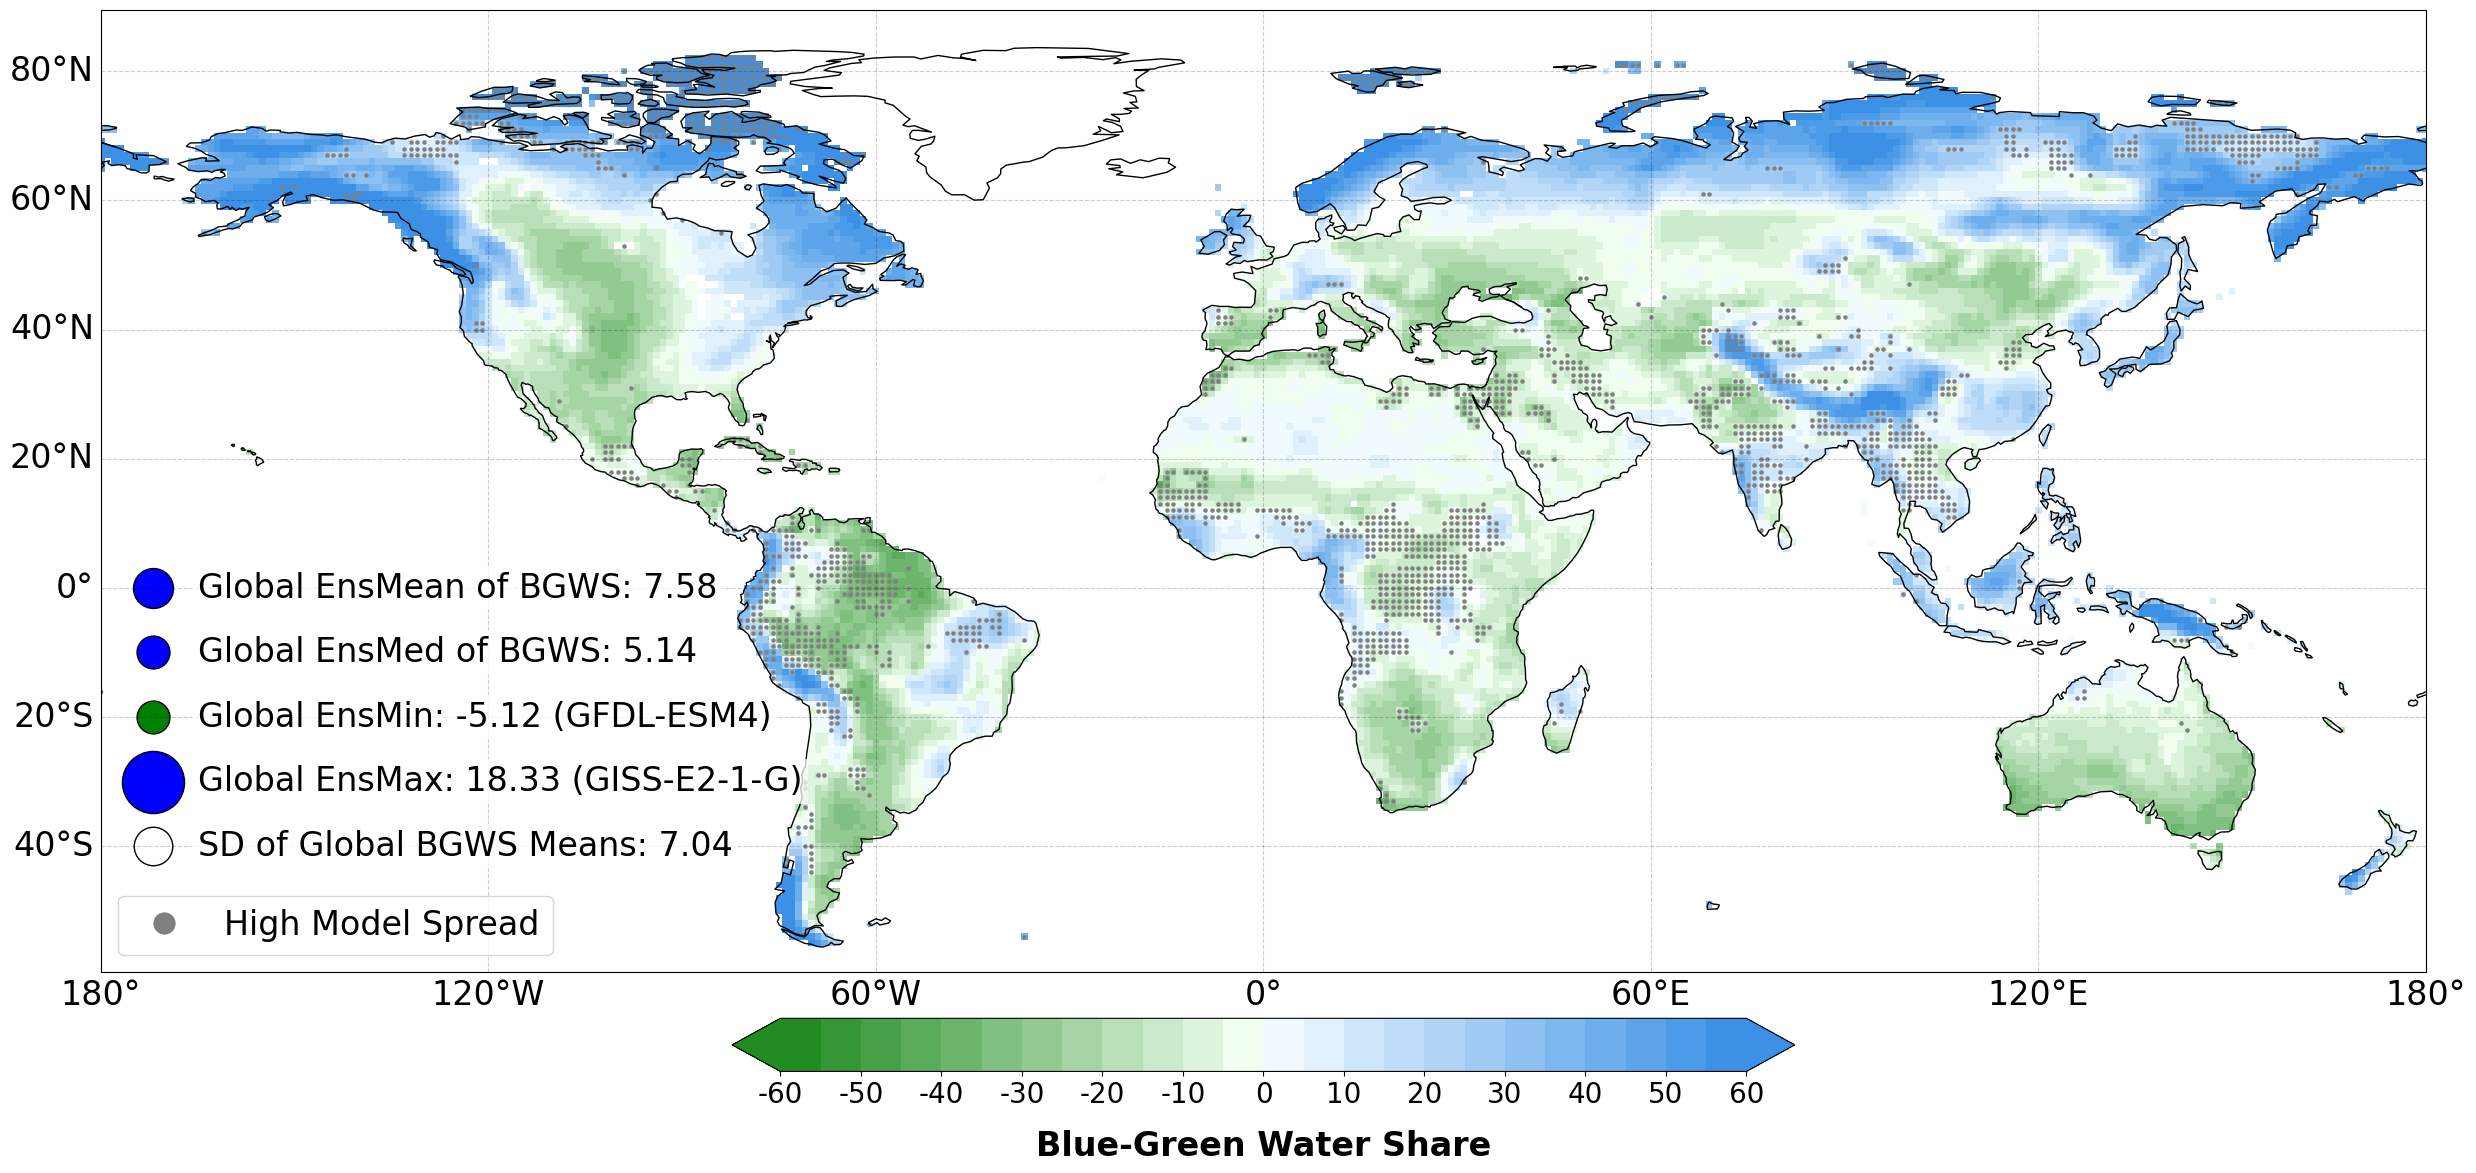

In [83]:
global_mean_models_ssp370 = plot_ensemble_data_on_map(ds_dict[period], 'bgws', period, save_fig=False)

In [46]:
models

['BCC-CSM2-MR',
 'CAMS-CSM1-0',
 'CESM2-WACCM',
 'CNRM-ESM2-1',
 'GISS-E2-1-G',
 'MIROC-ES2L',
 'NorESM2-MM',
 'UKESM1-0-LL',
 'CanESM5',
 'CNRM-CM6-1',
 'GFDL-ESM4',
 'MPI-ESM1-2-LR',
 'TaiESM1']

In [45]:
global_mean_models_historical

<xarray.DataArray 'bgws' (model: 13)>
array([18.847437  ,  5.172427  , 11.336275  , -1.7859088 , 17.071806  ,
        6.7852883 , 12.794473  ,  6.5200243 , 16.802113  , -1.8780121 ,
       -3.646278  ,  0.28599575,  3.0493803 ], dtype=float32)
Dimensions without coordinates: model

In [ ]:
plot_ensemble_data_on_map(ds_dict_prog_veg[period], 'bgws', period, save_fig=False)

In [ ]:
plot_ensemble_data_on_map(ds_dict_no_prog_veg[period], 'bgws', period, save_fig=False)

### Create BGWS table

In [86]:
def save_combined_global_mean_table(models, global_mean_models_historical, global_mean_models_ssp370, save_dir, filename='Global_Mean_BGWS_Table.csv'):
    """
    Save the combined global mean BGWS data to a CSV file and compute the change, ensemble mean, and median.

    Parameters:
    models (list): List of model names.
    global_mean_models_historical (xarray.DataArray): DataArray containing global mean BGWS values for the historical period.
    global_mean_models_ssp370 (xarray.DataArray): DataArray containing global mean BGWS values for the SSP370 scenario.
    save_dir (str): Directory where the CSV file will be saved.
    filename (str): Name of the CSV file. Default is 'Global_Mean_BGWS_Table.csv'.
    """
    # Compute the change
    change = global_mean_models_ssp370 - global_mean_models_historical

    # Combine the models and global mean data into a DataFrame
    data = {
        'Model': models,
        'Global Mean BGWS Historical': global_mean_models_historical.values,
        'Global Mean BGWS SSP370': global_mean_models_ssp370.values,
        'Change': change.values
    }

    df = pd.DataFrame(data)

    # Compute ensemble statistics
    ensemble_stats = {
        'Model': ['Ensemble Mean', 'Ensemble Median'],
        'Global Mean BGWS Historical': [
            global_mean_models_historical.mean().item(),
            global_mean_models_historical.median().item()
        ],
        'Global Mean BGWS SSP370': [
            global_mean_models_ssp370.mean().item(),
            global_mean_models_ssp370.median().item()
        ],
        'Change': [
            change.mean().item(),
            change.median().item()
        ]
    }

    df_ensemble = pd.DataFrame(ensemble_stats)
    df = pd.concat([df, df_ensemble], ignore_index=True)

    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    filepath = os.path.join(save_dir, filename)

    # Save the DataFrame to a CSV file
    df.to_csv(filepath, index=False)

    print(f"Table saved to {filepath}")

    return filepath

/work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/tables


In [87]:
# Call the function to save the table
bgws_table=global_mean_table(models, global_mean_models_historical, global_mean_models_ssp370, save_dir)
bgws_table

Table saved to /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/tables/Global_Mean_BGWS_Table.csv


,Model,Global Mean BGWS Historical,Global Mean BGWS SSP370
0,BCC-CSM2-MR,18.847437,17.147795
1,CAMS-CSM1-0,5.172427,4.124902
2,CESM2-WACCM,11.336275,12.140792
3,CNRM-ESM2-1,-1.785909,0.553069
4,GISS-E2-1-G,17.071806,18.329166
5,MIROC-ES2L,6.785288,5.016847
6,NorESM2-MM,12.794473,13.034206
7,UKESM1-0-LL,6.520024,10.512986
8,CanESM5,16.802113,12.543724
9,CNRM-CM6-1,-1.878012,0.490335


### Plot BGWS latitude plot

In [ ]:
def plot_ensemble_mean_lat(ds_dict, variable, period, statistic, save_fig=False):
    """
    Function to plot a longitudinal line plot of the ensemble mean for the specified variable,
    averaged over latitude. The area between the line and the zero-line will be colored.
    """
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(6, 9))
    
    # Extract the ensemble mean dataset
    ensemble_mean = ds_dict['Ensemble mean'][variable]

    # Average over latitude
    mean_lat =getattr(ensemble_mean, statistic)(dim='lon')
    
    # Plot the line
    lats = mean_lat.lat.values
    values = mean_lat.values
    #line = ax.plot(values, lats, color='black', label=f'{statistic.title()} $\Delta$BGWS by Latitude')
    line = ax.plot(values, lats, color='black', label=f'{statistic.title()} BGWS by Latitude')


    # Fill between the line and zero
    ax.fill_betweenx(lats, values, 0, where=(values > 0), facecolor=deep_blue, interpolate=True, alpha=0.5)
    ax.fill_betweenx(lats, values, 0, where=(values <= 0), facecolor=deep_green, interpolate=True, alpha=0.5)

    # Set labels and title
    ax.set_xlabel(f'BGWS')
    #ax.set_xlabel(f'$\Delta$BGWS')
    ax.set_ylabel('Latitude')
    #ax.set_title(f'Latitudinal {statistic.title()} of $\Delta$BGWS')
    ax.set_title(f'Latitudinal {statistic.title()} of BGWS')

    # Add grid, legend, and customizations as needed
    ax.grid(True)
    ax.legend(loc='upper right')

    plt.show()

    # Safe figure
    if save_fig:
        savepath = os.path.join('../..', 'results', 'CMIP6', period, 'time', 'mean', 'map')
        os.makedirs(savepath, exist_ok=True)
        filename = f'latitudinal_{statistic}.ensemble_mean.{variable}.pdf'
        filepath = os.path.join(savepath, filename)
        fig.savefig(filepath, dpi=600, bbox_inches='tight', format='pdf')
        return filepath
    else:
        return 'Figure not saved. If you want to save the figure add save_fig=True to the function call'

In [ ]:
period = 'historical-ssp370'

In [ ]:
plot_ensemble_mean_lat(ds_dict_change[period], 'bgws', period, 'mean', save_fig=True)

### Plot BGWS with Regions

In [ ]:
from shapely.geometry import MultiPolygon, Polygon

def split_polygon(polygon, meridian=180):
    """
    Splits a Shapely polygon into two polygons at a specified meridian
    """
    minx, miny, maxx, maxy = polygon.bounds
    if maxx > meridian and minx < -meridian:
        # Polygon crosses the antimeridian
        left_poly = []
        right_poly = []
        for x, y in polygon.exterior.coords:
            if x >= meridian:
                right_poly.append((x - 360, y))  # Wraparound for the right side
                print(f'Wraparound for the right side')
            else:
                left_poly.append((x, y))
                print(f'left_poly.append((x, y))')
        return [Polygon(left_poly), Polygon(right_poly)]
    else:
        print(f'nothing')
        return [polygon]  # Wrap the single polygon in a list for consistency

In [ ]:
def plot_regions_with_uncertainty(ds_dict, ds_dict_regions, variable, period, save_fig=False):
    """
    Plot regions with the ensemble mean of the specified variable,
    annotated with regions of high uncertainty based on standard deviation,
    visualizing areas where uncertainty is distinct.
    """
    fig = plt.figure(figsize=(30, 15))
    ax_main = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    
    # Assuming 'Ensemble mean' is already calculated and included in ds_dict
    ensemble_ds = ds_dict['Ensemble mean'][variable]
    
    for name, ds in ds_dict.items():
        if 'member_id' in ds.coords:
            ds = ds.drop('member_id')
    
    # Plot the selected variable from the dataset
    img = ensemble_ds.plot(ax=ax_main, vmin=-60, vmax=60, cmap=cm, transform=ccrs.PlateCarree(), add_colorbar=False)
    
     # Exclude 'Ensemble mean' and 'Ensemble median' for uncertainty calculation
    models_ds = xr.concat([ds[variable] for name, ds in ds_dict.items() if "Ensemble" not in name], dim='model')
    std_dev = models_ds.std(dim='model')

    # Define high uncertainty thresholds
    std_dev_threshold = std_dev.mean() + std_dev.std()
        
    # Identify grid points with high Std Dev and IQR
    high_std_dev = std_dev > std_dev_threshold
    
    # Visualize: Assuming you have latitude and longitude coordinates in your DataArray
    lon, lat = np.meshgrid(ensemble_ds.lon, ensemble_ds.lat)  # Adjust if necessary
    
    # For exclusive High Std Dev (not combined with high IQR)
    ax_main.scatter(lon[high_std_dev], lat[high_std_dev], color='grey', marker='.', s=20, transform=ccrs.PlateCarree())

    # Add coastlines and gridlines for context
    ax_main.coastlines()
    ax_main.tick_params(axis='both', which='major', labelsize=20)
    gridlines = ax_main.gridlines(draw_labels=True, color='black', alpha=0.2, linestyle='--')
    gridlines.top_labels = gridlines.right_labels = False
    gridlines.xlabel_style = {'size': 24}
    gridlines.ylabel_style = {'size': 24}

    # Get region bounds using regionmask
    land_regions = regionmask.defined_regions.ar6.land

    # Exclude 'Ensemble mean' and 'Ensemble median' for uncertainty calculation
    models_ds = xr.concat([ds[variable] for name, ds in ds_dict.items() if "Ensemble" not in name], dim='model')
    std_dev = models_ds.std(dim='model')
    
    # Use regionmask to define regions on the map
    land_regions = regionmask.defined_regions.ar6.land
    
    # Loop over the regions and overlay uncertainty based on std deviation from regional ensemble mean
    for region_number in land_regions.numbers:
        if region_number in ds_dict_regions['Ensemble mean'][variable].region.values:
            region_name = ds_dict_regions['Ensemble mean'].names.sel(region=region_number).item()
            if region_name.lower() == 'land':
                continue  # Skip the 'land' region

            region_ds = ds_dict_regions['Ensemble mean'].sel(region=region_number)
            region_mean = region_ds[variable].mean().item()
            region_abbr = region_ds.abbrevs.values[region_ds.region.values == region_number][0]
            
            # Compute std of regional mean across models
            models_ds_region = xr.concat([ds[variable].sel(region=region_number) for name, ds in ds_dict_regions.items() if "Ensemble" not in name], dim='model')
            regional_mean_models = models_ds_region.mean(dim=['lat', 'lon'])
            regional_std_dev_models = regional_mean_models.std(dim='model').item()
            
            # Fetch the polygon for this region
            region_obj = land_regions[region_number]
            if hasattr(region_obj, 'polygons'):
                region_polygons = region_obj.polygons
            elif hasattr(region_obj, 'polygon'):
                region_polygons = [region_obj.polygon]
            else:
                continue
                
            for region_polygon in region_polygons:
                feature = ShapelyFeature([region_polygon], ccrs.PlateCarree(), edgecolor='gray', facecolor='none', linewidth=2, alpha=0.7)
                ax_main.add_feature(feature, zorder=1)
                
                region_obj = land_regions[region_number]
                region_polygons = getattr(region_obj, 'polygons', [region_obj.polygon]) if hasattr(region_obj, 'polygons') or hasattr(region_obj, 'polygon') else []

                centroid = region_polygon.centroid.coords[0]

                # Scale marker sizes for visibility
                base_scaling_factor = 200
                marker_size_mean = np.sqrt(abs(region_mean)) * base_scaling_factor
                marker_size_std = np.sqrt(abs(regional_std_dev_models)) * base_scaling_factor
                
                # Get marker color
                color = 'blue' if region_mean > 0 else 'green'

                # Place a single marker at the centroid of each region
                if (region_name == 'West&Central-Europe' 
                    or region_name == 'N.Australia' 
                    or region_name == 'Greenland/Iceland'
                    or region_name == 'C.Australia'
                    or region_name == 'E.C.Asia'
                    or region_name == 'Tibetan-Plateau'
                    or region_name == 'Russian-Arctic'
                    or region_name == 'Sahara'
                    or region_name =='S.Asia'
                   ):
                    ax_main.scatter(centroid[0]-1.1, centroid[1], s=marker_size_mean, color=color, alpha=1, 
                                    transform=ccrs.PlateCarree(), edgecolor='black', zorder=2)
                    ax_main.scatter(centroid[0]+7.1, centroid[1], s=marker_size_std,  facecolors='white', 
                                    edgecolors='black', transform=ccrs.PlateCarree(), zorder=2) 
                
                    # Annotate the region with abbreviation and marker
                    ax_main.text(centroid[0]-12.1, centroid[1], f"{region_abbr}",
                                 horizontalalignment='center', verticalalignment='center', transform=ccrs.PlateCarree(),
                                 fontsize=24, rotation=0, 
                                 bbox=dict(facecolor='white', alpha=0.75, edgecolor='none')) 
                elif (region_name == 'N.Eastern-Africa'
                      or region_name == 'S.Eastern-Africa'
                     ):
                    ax_main.scatter(centroid[0]+7.1, centroid[1], s=marker_size_mean, color=color, alpha=1, 
                                    transform=ccrs.PlateCarree(), edgecolor='black', zorder=2)
                    ax_main.scatter(centroid[0]+15.1, centroid[1], s=marker_size_std,  facecolors='white', 
                                    edgecolors='black', transform=ccrs.PlateCarree(), zorder=2) 
                
                    # Annotate the region with abbreviation and marker
                    ax_main.text(centroid[0]-4.1, centroid[1], f"{region_abbr}",
                                 horizontalalignment='center', verticalalignment='center', transform=ccrs.PlateCarree(),
                                 fontsize=24, rotation=0, 
                                 bbox=dict(facecolor='white', alpha=0.75, edgecolor='none')) 
                elif (region_name == 'N.Central-America'
                      or region_name == 'S.Central-America'
                     ):
                    ax_main.scatter(centroid[0]-4.1, centroid[1]-4, s=marker_size_mean, color=color, alpha=1, 
                                    transform=ccrs.PlateCarree(), edgecolor='black', zorder=2)
                    ax_main.scatter(centroid[0]+4.1, centroid[1]-4, s=marker_size_std,  facecolors='white', 
                                    edgecolors='black', transform=ccrs.PlateCarree(), zorder=2) 
                
                    # Annotate the region with abbreviation and marker
                    ax_main.text(centroid[0]-5.1, centroid[1]+4, f"{region_abbr}",
                                 horizontalalignment='center', verticalalignment='center', transform=ccrs.PlateCarree(),
                                 fontsize=24, rotation=0, 
                                 bbox=dict(facecolor='white', alpha=0.75, edgecolor='none')) 
                else:
                    ax_main.scatter(centroid[0]-4.1, centroid[1]-4, s=marker_size_mean, color=color, alpha=1, 
                                    transform=ccrs.PlateCarree(), edgecolor='black', zorder=2)
                    ax_main.scatter(centroid[0]+4.1, centroid[1]-4, s=marker_size_std,  facecolors='white', 
                                    edgecolors='black', transform=ccrs.PlateCarree(), zorder=2) 
                
                    # Annotate the region with abbreviation and marker
                    ax_main.text(centroid[0], centroid[1]+4, f"{region_abbr}",
                                 horizontalalignment='center', verticalalignment='center', transform=ccrs.PlateCarree(),
                                 fontsize=24, rotation=0, 
                                 bbox=dict(facecolor='white', alpha=0.75, edgecolor='none')) 

                
    # Add colorbar and legend
    cbar = fig.colorbar(img, ax=ax_main, orientation='horizontal', fraction=0.046, pad=0.04, extend='both')
    cbar.set_label("Blue-Green Water Share", fontsize=24, weight='bold', labelpad=15) 
    cbar.ax.tick_params(labelsize=20)
    
    # Create custom handles
    # Here, 'ms' is the marker size, adjust it as needed
    std_dev_handle = mlines.Line2D([], [], color='grey', marker='.', linestyle='None', markersize=30, 
                                   label='$\sigma$ > $\mu_{\sigma}$ + $\sigma_{\sigma}$')
    mean_handle = mlines.Line2D([], [], color='white', marker='o', linestyle='None', markersize=30, 
                                markeredgecolor='black', markerfacecolor='green', markerfacecoloralt='blue', fillstyle = 'left', label='Regional EnsMean of BGWS')
    std_handle = mlines.Line2D([], [], color='white', marker='o', linestyle='None', markersize=30, 
                               markeredgecolor='black', markerfacecolor='white', label='SD of Regional BGWS Means')   
    
    # Pass custom handles to the legend
    ax_main.legend(handles=[mean_handle, std_handle, std_dev_handle], loc='lower left', fontsize=24)

    plt.show()
    
    # Safe figure
    if save_fig:
        savepath = os.path.join('../..', 'results', 'CMIP6', period, 'time', 'mean', 'map')
        os.makedirs(savepath, exist_ok=True)
        filename = f'Ensemble_mean.{variable}.map.regions_winter.pdf'
        filepath = os.path.join(savepath, filename)
        fig.savefig(filepath, dpi=600, bbox_inches='tight', format='pdf')
    else:
        filepath = 'Figure not saved. If you want to save the figure add save_fig=True to the function call'
        
    return filepath

In [ ]:
period = 'ssp370'
plot_regions_with_uncertainty(ds_dict[period], ds_dict_regions[period], 'bgws', period, save_fig=True)

### Plot BGWS with zoomed in Regions

In [ ]:
# Function to calculate dynamic font size
def calculate_font_size(minx, maxx, miny, maxy, base_font_size=18):
    """
    Dynamically calculate font size based on the extent of the map.
    
    Args:
        minx, maxx, miny, maxy: Extent of the map.
        base_font_size: Base size to adjust from.
        
    Returns:
        Adjusted font size.
    """
    # Example calculation - this can be adjusted based on your needs
    width = maxx - minx
    height = maxy - miny
    scale_factor = np.sqrt(width * height) / 22  # Example scaling factor - adjust as needed
    print(scale_factor)
    return max(base_font_size * scale_factor, base_font_size)

In [ ]:
def plot_region_zoom_with_uncertainty(ds_dict, ds_dict_regions, variable, region_name, period, save_fig=False):
    fig = plt.figure(figsize=(30, 15))
    
    ensemble_ds = ds_dict['Ensemble mean'][variable]
    
    for name, ds in ds_dict.items():
        if 'member_id' in ds.coords:
            ds_dict[name] = ds.drop('member_id')
    for name, ds in ds_dict_regions.items():
        if 'member_id' in ds_dict_regions[name].coords:
            ds_dict_regions[name] = ds_dict_regions[name].drop('member_id')
    
    # Additional code to plot all polygons and adjust zoom
    land_regions = regionmask.defined_regions.ar6.land
    selected_region = land_regions[region_name]
    
    if hasattr(selected_region, 'polygons'):  # For regions with multiple polygons
        all_polygons = selected_region.polygons
    else:  # For regions defined by a single polygon
        all_polygons = [selected_region.polygon]
        
    # Calculating the combined bounds of all polygons to adjust zoom
    minx, miny, maxx, maxy = np.inf, np.inf, -np.inf, -np.inf
    
    for geom in all_polygons:
        if isinstance(geom, Polygon):
            # Directly calculate bounds for a Polygon
            p_minx, p_miny, p_maxx, p_maxy = geom.bounds
            minx, miny = min(minx, p_minx), min(miny, p_miny)
            maxx, maxy = max(maxx, p_maxx), max(maxy, p_maxy)
            ax_main = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
            img = ensemble_ds.plot(ax=ax_main, vmin=-60, vmax=60, cmap=cm, transform=ccrs.PlateCarree(), add_colorbar=False)
            ax_main.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
        elif isinstance(geom, MultiPolygon):
            # Iterate over each polygon in the MultiPolygon to calculate bounds
            ax_main = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
            img = ensemble_ds.plot(ax=ax_main, vmin=-60, vmax=60, cmap=cm, transform=ccrs.PlateCarree(), add_colorbar=False)
                
            minx, maxx = -np.inf, np.inf
            for polygon in geom:
                p_minx, p_miny, p_maxx, p_maxy = polygon.bounds
                minx, miny = max(minx, p_minx), min(miny, p_miny)
                maxx, maxy = min(maxx, p_maxx), max(maxy, p_maxy)
                ax_main.add_geometries([polygon], crs=ccrs.PlateCarree(), edgecolor='black', facecolor='none')

   # Adjusting map extent with a small buffer
    buffer = 2  # Adjust the buffer size as needed
    
    if maxx < minx:
        maxx_ = 360 + maxx
    else:
        maxx_ = maxx
    
    if maxx_ == 180:
        ax_main.set_extent([minx - buffer, min((maxx_ + buffer), 180), miny - buffer , maxy + buffer], crs=ccrs.PlateCarree())
    else:
        ax_main.set_extent([minx - buffer, maxx_ + buffer, miny - buffer , maxy + buffer], crs=ccrs.PlateCarree())
    #print(minx - buffer, maxx_ + buffer, miny - buffer, maxy + buffer)
    
    #font_size = calculate_font_size(minx, maxx_, miny, maxy)
  
    # Compute the stats for uncertainty dots
    models_ds = xr.concat([ds[variable] for name, ds in ds_dict.items() if "Ensemble" not in name], dim='model')
    std_dev = models_ds.std(dim='model')
    std_dev_threshold = std_dev.mean() + std_dev.std()
    high_std_dev = std_dev > std_dev_threshold
    
    lon, lat = np.meshgrid(ensemble_ds.lon, ensemble_ds.lat)
    
    ax_main.scatter(lon[high_std_dev], lat[high_std_dev], color='grey', marker='.', s=200, transform=ccrs.PlateCarree())

    # Add coastlines and gridlines for context
    ax_main.coastlines()
    ax_main.tick_params(axis='both', which='major', labelsize=20)
    gridlines = ax_main.gridlines(draw_labels=True, color='black', alpha=0.2, linestyle='--')
    gridlines.top_labels = gridlines.right_labels = False
    gridlines.xlabel_style = {'size': 24}
    gridlines.ylabel_style = {'size': 24}

    # Overlay uncertainty and mean ± std text for the zoomed region
    region_ds = ds_dict_regions['Ensemble mean'].sel(region=selected_region.number)
    region_mean = region_ds[variable].mean().item()
    
    # Compute std of regional mean across models
    models_ds_region = xr.concat([ds[variable].sel(region=selected_region.number) for name, ds in ds_dict_regions.items() if "Ensemble" not in name], dim='model')
    regional_mean_models = models_ds_region.mean(dim=['lat', 'lon'])
    regional_std_dev_models = regional_mean_models.std(dim='model').item()
    
    # Assuming selected_region is a polygon and we're accessing its centroid    
    centroid = selected_region.centroid

    # Now use centroid[0] and centroid[1] as the longitude and latitude
    ax_main.text(centroid[0], centroid[1], f'Mean: {region_mean:.2f} \n ± {regional_std_dev_models:.2f}',
                 fontsize=38, ha='center', va='bottom', transform=ccrs.PlateCarree(),
                 bbox=dict(boxstyle="round", facecolor='white', alpha=0.5))
    
    # Add colorbar and legend
    cbar = fig.colorbar(img, ax=ax_main, orientation='horizontal', fraction=0.046, pad=0.04, extend='both')
    cbar.set_label("Blue-Green Water Share", fontsize=24, weight='bold', labelpad=15) 
    cbar.ax.tick_params(labelsize=20)
    
    std_dev_handle = mlines.Line2D([], [], color='grey', marker='.', linestyle='None', markersize=30, 
                                   label='High Model Spread')
  
    ax_main.legend(handles=[std_dev_handle], loc='lower left', fontsize=24)

    plt.show()

    if save_fig:
        region_names = region_name.replace("/", "_")
        savepath = os.path.join('../..', 'results', 'CMIP6', period, 'time', 'mean', 'regional_maps')
        os.makedirs(savepath, exist_ok=True)
        filename = f'Ensemble_mean_{variable}_region_zoom_{region_names}.pdf'
        filepath = os.path.join(savepath, filename)
        fig.savefig(filepath, dpi=600, bbox_inches='tight', format='pdf')
    else:
        filepath = 'Figure not saved. Add save_fig=True to save the figure.'

    return filepath

In [ ]:
period = 'historical'
for names in ds_dict_regions[period]['BCC-CSM2-MR'].names.values:
    # Skip the iteration if the name is 'land'
    if names == 'land':
        continue
    plot_region_zoom_with_uncertainty(ds_dict[period], ds_dict_regions[period], 'bgws', names, period, save_fig=True)

### Plot Global BGWS Change

In [ ]:
def plot_global_BGWS_change(ds_dict, variable, period, save_fig=False):
    """
    Enhanced function to plot a map with the ensemble mean of the specified variable,
    annotated with regions of high uncertainty based on both standard deviation and
    interquartile range, visualizing areas where both conditions apply distinctly.
    """
    # Initialize the plot with a cartopy projection
    fig = plt.figure(figsize=(30, 15))
    ax_main = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    
    ensemble_ds = ds_dict['Ensemble mean'][variable]
    
    for name, ds in ds_dict.items():
        if 'member_id' in ds.coords:
            ds = ds.drop('member_id')
    
    # Plot the selected variable from the dataset
    img = ensemble_ds.plot(ax=ax_main, vmin=-50, vmax=50, cmap=cm, transform=ccrs.PlateCarree(), add_colorbar=False)

    # Add coastlines and gridlines for context
    ax_main.coastlines()
    ax_main.tick_params(axis='both', which='major', labelsize=20)
    gridlines = ax_main.gridlines(draw_labels=True, color='black', alpha=0.2, linestyle='--')
    gridlines.top_labels = gridlines.right_labels = False
    gridlines.xlabel_style = {'size': 24}
    gridlines.ylabel_style = {'size': 24}
    
    # Exclude 'Ensemble mean' and 'Ensemble median' for uncertainty calculation
    models_ds = xr.concat([ds[variable] for name, ds in ds_dict.items() if "Ensemble" not in name], dim='model')
    std_dev = models_ds.std(dim='model')

    # Define high uncertainty thresholds
    std_dev_threshold = std_dev.mean() + std_dev.std()
        
    # Identify grid points with high Std Dev and IQR
    high_std_dev = std_dev > std_dev_threshold
    
    # Visualize: Assuming you have latitude and longitude coordinates in your DataArray
    lon, lat = np.meshgrid(ensemble_ds.lon, ensemble_ds.lat)  # Adjust if necessary
    
    # For exclusive High Std Dev (not combined with high IQR)
    ax_main.scatter(lon[high_std_dev], lat[high_std_dev], color='grey', marker='.', s=20, transform=ccrs.PlateCarree())

    # Calculate global mean across models for presentation
    global_mean_ensmean = ensemble_ds.mean().item()

    # Compute std of global mean across models
    global_mean_models = models_ds.mean(dim=['lat', 'lon'])
    
    global_median_ensmean = global_mean_models.median().item()

    # Calculate standard deviation of global means across models
    global_std_dev_models = global_mean_models.std(dim='model').item()

    # Find the minimum and maximum global mean values and their corresponding model names
    min_global_mean = global_mean_models.min().item()
    min_model = global_mean_models.argmin(dim='model').item()
    max_global_mean = global_mean_models.max().item()
    max_model = global_mean_models.argmax(dim='model').item()

    # Model names
    min_model_name = list(ds_dict)[min_model]
    max_model_name = list(ds_dict)[max_model]
    
    # Get Marker size
    mean_color = 'blue' if global_mean_ensmean > 0 else 'green'
    med_color = 'blue' if global_median_ensmean > 0 else 'green'
    min_color = 'blue' if min_global_mean > 0 else 'green'
    max_color = 'blue' if max_global_mean > 0 else 'green'
    max_abs_mean_val = np.abs(global_mean_models.max().item())  # Assuming this intends to find the maximum value in the ensemble mean dataset
    
    base_scaling_factor = 2000
    
    # Example of exponential scaling
    exponential_factor = 4  # Adjust based on desired emphasis
    mean_marker_size = (abs(global_mean_ensmean) / max_abs_mean_val) * base_scaling_factor
    std_marker_size = (abs(global_std_dev_models) / max_abs_mean_val) * base_scaling_factor
    med_marker_size = (abs(global_median_ensmean) / max_abs_mean_val) * base_scaling_factor
    min_marker_size = (abs(min_global_mean) / max_abs_mean_val) * base_scaling_factor
    max_marker_size = (abs(max_global_mean) / max_abs_mean_val) * base_scaling_factor

    # Global Mean
    # left , up
    ax_main.scatter(-172, 0, s=mean_marker_size, color=mean_color, alpha=1, transform=ccrs.PlateCarree(), edgecolor='black', zorder=2)
    ax_main.text(-165, 0, f"Global EnsMean of $\Delta$ BGWS: {round(global_mean_ensmean, 2)}", horizontalalignment='left', verticalalignment='center', transform=ccrs.PlateCarree(), fontsize=24, rotation=0, bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))

    # Median
    ax_main.scatter(-172, -10, s=med_marker_size, color=med_color, alpha=1, transform=ccrs.PlateCarree(), edgecolor='black', zorder=2)
    ax_main.text(-165, -10, f"Global EnsMed of $\Delta$ BGWS: {round(global_median_ensmean, 2)}", horizontalalignment='left', verticalalignment='center', transform=ccrs.PlateCarree(), fontsize=24, rotation=0, bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
    
    # Min
    ax_main.scatter(-172, -20, s=min_marker_size, color=min_color, alpha=1, transform=ccrs.PlateCarree(), edgecolor='black', zorder=2)
    ax_main.text(-165, -20, f"Global EnsMin: {round(min_global_mean, 2)} ({min_model_name})", horizontalalignment='left', verticalalignment='center', transform=ccrs.PlateCarree(), fontsize=24, rotation=0, bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
    
    # Max
    ax_main.scatter(-172, -30, s=max_marker_size, color=max_color, alpha=1, transform=ccrs.PlateCarree(), edgecolor='black', zorder=2)
    ax_main.text(-165, -30, f"Global EnsMax: {round(max_global_mean, 2)} ({max_model_name})", horizontalalignment='left', verticalalignment='center', transform=ccrs.PlateCarree(), fontsize=24, rotation=0, bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
    
    # Standard Deviation of global means
    ax_main.scatter(-172, -40, s=std_marker_size, facecolors='white', edgecolors='black', transform=ccrs.PlateCarree(), zorder=2) 
    ax_main.text(-165, -40, f"SD of Global $\Delta$ BGWS Means: {round(global_std_dev_models, 2)}", horizontalalignment='left', verticalalignment='center', transform=ccrs.PlateCarree(), fontsize=24, rotation=0, bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))

    # Add colorbar and legend
    cbar = fig.colorbar(img, ax=ax_main, orientation='horizontal', fraction=0.046, pad=0.04, extend='both')
    cbar.set_label("$\Delta$ Blue-Green Water Share", fontsize=24, weight='bold', labelpad=15) 
    cbar.ax.tick_params(labelsize=20)
    
    # Create custom handles
    # Here, 'ms' is the marker size, adjust it as needed
    std_dev_handle = mlines.Line2D([], [], color='grey', marker='.', linestyle='None', markersize=30, label='$\sigma$ > $\mu_{\sigma}$ + $\sigma_{\sigma}$')

    # Pass custom handles to the legend
    ax_main.legend(handles=[std_dev_handle], loc='lower left', fontsize=24)

    plt.show()
    
    # Safe figure
    if save_fig:
        savepath = os.path.join('../..', 'results', 'CMIP6', period, 'time', 'mean', 'change_map')
        os.makedirs(savepath, exist_ok=True)
        filename = f'Ensemble_mean_change.{variable}.map.with_median_winter.pdf'
        filepath = os.path.join(savepath, filename)
        fig.savefig(filepath, dpi=600, bbox_inches='tight', format='pdf')
    else:
        filepath = 'Figure not saved. If you want to save the figure add save_fig=True to the function call'
        
    return global_mean_models

In [ ]:
period = 'ssp370-historical'
for name, ds in ds_dict_change[period].items():
    if 'member_id' in ds.coords: 
        print('ture')
        ds_dict_change[period][name] = ds_dict_change[period][name].drop('member_id')

In [ ]:
plot_global_BGWS_change(ds_dict_change[period], 'bgws', period, save_fig=False)

In [ ]:
ds_dict_change[period].keys()

### Plot BGWS Change with Regions

In [ ]:
def plot_regions_change_with_uncertainty(ds_dict, ds_dict_regions, variable, period, save_fig=False):
    """
    Plot regions with the ensemble mean of the specified variable,
    annotated with regions of high uncertainty based on standard deviation,
    visualizing areas where uncertainty is distinct.
    """
    fig = plt.figure(figsize=(30, 15))
    ax_main = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    
    # Assuming 'Ensemble mean' is already calculated and included in ds_dict
    ensemble_ds = ds_dict['Ensemble mean'][variable]
    
    for name, ds in ds_dict.items():
        if 'member_id' in ds.coords:
            ds = ds.drop('member_id')
    
    # Plot the selected variable from the dataset
    img = ensemble_ds.plot(ax=ax_main, vmin=-10, vmax=10, cmap=cm, transform=ccrs.PlateCarree(), add_colorbar=False)
    
     # Exclude 'Ensemble mean' and 'Ensemble median' for uncertainty calculation
    models_ds = xr.concat([ds[variable] for name, ds in ds_dict.items() if "Ensemble" not in name], dim='model')
    std_dev = models_ds.std(dim='model')

    # Define high uncertainty thresholds
    std_dev_threshold = std_dev.mean() + std_dev.std()
        
    # Identify grid points with high Std Dev and IQR
    high_std_dev = std_dev > std_dev_threshold
    
    # Visualize: Assuming you have latitude and longitude coordinates in your DataArray
    lon, lat = np.meshgrid(ensemble_ds.lon, ensemble_ds.lat)  # Adjust if necessary
    
    # For exclusive High Std Dev (not combined with high IQR)
    ax_main.scatter(lon[high_std_dev], lat[high_std_dev], color='grey', marker='.', s=20, transform=ccrs.PlateCarree())

    # Add coastlines and gridlines for context
    ax_main.coastlines()
    ax_main.tick_params(axis='both', which='major', labelsize=20)
    gridlines = ax_main.gridlines(draw_labels=True, color='black', alpha=0.2, linestyle='--')
    gridlines.top_labels = gridlines.right_labels = False
    gridlines.xlabel_style = {'size': 24}
    gridlines.ylabel_style = {'size': 24}

    # Get region bounds using regionmask
    land_regions = regionmask.defined_regions.ar6.land

    # Exclude 'Ensemble mean' and 'Ensemble median' for uncertainty calculation
    models_ds = xr.concat([ds[variable] for name, ds in ds_dict.items() if "Ensemble" not in name], dim='model')
    std_dev = models_ds.std(dim='model')
    
    # Use regionmask to define regions on the map
    land_regions = regionmask.defined_regions.ar6.land
    
    # Loop over the regions and overlay uncertainty based on std deviation from regional ensemble mean
    for region_number in land_regions.numbers:
        if region_number in ds_dict_regions['Ensemble mean'][variable].region.values:
            region_name = ds_dict_regions['Ensemble mean'].names.sel(region=region_number).item()
            if region_name.lower() == 'land':
                continue  # Skip the 'land' region

            region_ds = ds_dict_regions['Ensemble mean'].sel(region=region_number)
            region_mean = region_ds[variable].mean().item()
            region_abbr = region_ds.abbrevs.values[region_ds.region.values == region_number][0]
            
            # Compute std of regional mean across models
            models_ds_region = xr.concat([ds[variable].sel(region=region_number) for name, ds in ds_dict_regions.items() if "Ensemble" not in name], dim='model')
            regional_mean_models = models_ds_region.mean(dim=['lat', 'lon'])
            regional_std_dev_models = regional_mean_models.std(dim='model').item()
            
            # Fetch the polygon for this region
            region_obj = land_regions[region_number]
            if hasattr(region_obj, 'polygons'):
                region_polygons = region_obj.polygons
            elif hasattr(region_obj, 'polygon'):
                region_polygons = [region_obj.polygon]
            else:
                continue
                
            for region_polygon in region_polygons:
                feature = ShapelyFeature([region_polygon], ccrs.PlateCarree(), edgecolor='gray', facecolor='none', linewidth=2, alpha=0.7)
                ax_main.add_feature(feature, zorder=1)
                
                region_obj = land_regions[region_number]
                region_polygons = getattr(region_obj, 'polygons', [region_obj.polygon]) if hasattr(region_obj, 'polygons') or hasattr(region_obj, 'polygon') else []

                centroid = region_polygon.centroid.coords[0]

                # Scale marker sizes for visibility
                base_scaling_factor = 200
                marker_size_mean = np.sqrt(abs(region_mean)) * base_scaling_factor
                marker_size_std = np.sqrt(abs(regional_std_dev_models)) * base_scaling_factor
                
                # Get marker color
                color = 'blue' if region_mean > 0 else 'green'

                # Place a single marker at the centroid of each region
                if (region_name == 'West&Central-Europe' 
                    or region_name == 'N.Australia' 
                    or region_name == 'Greenland/Iceland'
                    or region_name == 'C.Australia'
                    or region_name == 'E.C.Asia'
                    or region_name == 'Tibetan-Plateau'
                    or region_name == 'Russian-Arctic'
                    or region_name == 'Sahara'
                    or region_name =='S.Asia'
                   ):
                    ax_main.scatter(centroid[0]-1.1, centroid[1], s=marker_size_mean, color=color, alpha=1, 
                                    transform=ccrs.PlateCarree(), edgecolor='black', zorder=2)
                    ax_main.scatter(centroid[0]+7.1, centroid[1], s=marker_size_std,  facecolors='white', 
                                    edgecolors='black', transform=ccrs.PlateCarree(), zorder=2) 
                
                    # Annotate the region with abbreviation and marker
                    ax_main.text(centroid[0]-12.1, centroid[1], f"{region_abbr}",
                                 horizontalalignment='center', verticalalignment='center', transform=ccrs.PlateCarree(),
                                 fontsize=24, rotation=0, 
                                 bbox=dict(facecolor='white', alpha=0.75, edgecolor='none')) 
                elif (region_name == 'N.Eastern-Africa'
                      or region_name == 'S.Eastern-Africa'
                     ):
                    ax_main.scatter(centroid[0]+7.1, centroid[1], s=marker_size_mean, color=color, alpha=1, 
                                    transform=ccrs.PlateCarree(), edgecolor='black', zorder=2)
                    ax_main.scatter(centroid[0]+15.1, centroid[1], s=marker_size_std,  facecolors='white', 
                                    edgecolors='black', transform=ccrs.PlateCarree(), zorder=2) 
                
                    # Annotate the region with abbreviation and marker
                    ax_main.text(centroid[0]-4.1, centroid[1], f"{region_abbr}",
                                 horizontalalignment='center', verticalalignment='center', transform=ccrs.PlateCarree(),
                                 fontsize=24, rotation=0, 
                                 bbox=dict(facecolor='white', alpha=0.75, edgecolor='none')) 
                elif (region_name == 'N.Central-America'
                      or region_name == 'S.Central-America'
                     ):
                    ax_main.scatter(centroid[0]-4.1, centroid[1]-4, s=marker_size_mean, color=color, alpha=1, 
                                    transform=ccrs.PlateCarree(), edgecolor='black', zorder=2)
                    ax_main.scatter(centroid[0]+4.1, centroid[1]-4, s=marker_size_std,  facecolors='white', 
                                    edgecolors='black', transform=ccrs.PlateCarree(), zorder=2) 
                
                    # Annotate the region with abbreviation and marker
                    ax_main.text(centroid[0]-5.1, centroid[1]+4, f"{region_abbr}",
                                 horizontalalignment='center', verticalalignment='center', transform=ccrs.PlateCarree(),
                                 fontsize=24, rotation=0, 
                                 bbox=dict(facecolor='white', alpha=0.75, edgecolor='none')) 
                else:
                    ax_main.scatter(centroid[0]-4.1, centroid[1]-4, s=marker_size_mean, color=color, alpha=1, 
                                    transform=ccrs.PlateCarree(), edgecolor='black', zorder=2)
                    ax_main.scatter(centroid[0]+4.1, centroid[1]-4, s=marker_size_std,  facecolors='white', 
                                    edgecolors='black', transform=ccrs.PlateCarree(), zorder=2) 
                
                    # Annotate the region with abbreviation and marker
                    ax_main.text(centroid[0], centroid[1]+4, f"{region_abbr}",
                                 horizontalalignment='center', verticalalignment='center', transform=ccrs.PlateCarree(),
                                 fontsize=24, rotation=0, 
                                 bbox=dict(facecolor='white', alpha=0.75, edgecolor='none')) 

                
    # Add colorbar and legend
    cbar = fig.colorbar(img, ax=ax_main, orientation='horizontal', fraction=0.046, pad=0.04, extend='both')
    cbar.set_label("$\Delta$ Blue-Green Water Share", fontsize=24, weight='bold', labelpad=15) 
    cbar.ax.tick_params(labelsize=20)
    
    # Create custom handles
    # Here, 'ms' is the marker size, adjust it as needed
    std_dev_handle = mlines.Line2D([], [], color='grey', marker='.', linestyle='None', markersize=30, 
                                   label='$\sigma$ > $\mu_{\sigma}$ + $\sigma_{\sigma}$')
    mean_handle = mlines.Line2D([], [], color='white', marker='o', linestyle='None', markersize=30, 
                                markeredgecolor='black', markerfacecolor='green', markerfacecoloralt='blue', fillstyle = 'left', label='Regional EnsMean of $\Delta$ BGWS')
    std_handle = mlines.Line2D([], [], color='white', marker='o', linestyle='None', markersize=30, 
                               markeredgecolor='black', markerfacecolor='white', label='SD of Regional $\Delta$ BGWS Means')   
    
    # Pass custom handles to the legend
    ax_main.legend(handles=[mean_handle, std_handle, std_dev_handle], loc='lower left', fontsize=24)

    plt.show()
    
    # Safe figure
    if save_fig:
        savepath = os.path.join('../..', 'results', 'CMIP6', period, 'time', 'mean', 'change_map')
        os.makedirs(savepath, exist_ok=True)
        filename = f'Ensemble_mean_change.{variable}.map.regions_winter.pdf'
        filepath = os.path.join(savepath, filename)
        fig.savefig(filepath, dpi=600, bbox_inches='tight', format='pdf')
    else:
        filepath = 'Figure not saved. If you want to save the figure add save_fig=True to the function call'
        
    return filepath

In [ ]:
period = 'historical-ssp370'
plot_regions_change_with_uncertainty(ds_dict_change[period], ds_dict_regions_change[period], 'bgws', period, save_fig=True)

### Plot BGWS Change with Regions

In [ ]:
def plot_region_change_zoom_with_uncertainty(ds_dict, ds_dict_regions, variable, region_name, period, save_fig=False):
    fig = plt.figure(figsize=(30, 15))
    
    ensemble_ds = ds_dict['Ensemble mean'][variable]
    
    for name, ds in ds_dict.items():
        if 'member_id' in ds.coords:
            ds_dict[name] = ds.drop('member_id')
    for name, ds in ds_dict_regions.items():
        if 'member_id' in ds_dict_regions[name].coords:
            ds_dict_regions[name] = ds_dict_regions[name].drop('member_id')
    
    # Additional code to plot all polygons and adjust zoom
    land_regions = regionmask.defined_regions.ar6.land
    selected_region = land_regions[region_name]
    
    if hasattr(selected_region, 'polygons'):  # For regions with multiple polygons
        all_polygons = selected_region.polygons
    else:  # For regions defined by a single polygon
        all_polygons = [selected_region.polygon]
        
    # Calculating the combined bounds of all polygons to adjust zoom
    minx, miny, maxx, maxy = np.inf, np.inf, -np.inf, -np.inf
    
    for geom in all_polygons:
        if isinstance(geom, Polygon):
            # Directly calculate bounds for a Polygon
            p_minx, p_miny, p_maxx, p_maxy = geom.bounds
            minx, miny = min(minx, p_minx), min(miny, p_miny)
            maxx, maxy = max(maxx, p_maxx), max(maxy, p_maxy)
            ax_main = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
            img = ensemble_ds.plot(ax=ax_main, vmin=-10, vmax=10, cmap=cm_change, transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False)
            ax_main.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
        elif isinstance(geom, MultiPolygon):
            # Iterate over each polygon in the MultiPolygon to calculate bounds
            ax_main = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
            img = ensemble_ds.plot(ax=ax_main, vmin=-10, vmax=10, cmap=cm_change, transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False)
                
            minx, maxx = -np.inf, np.inf
            for polygon in geom:
                p_minx, p_miny, p_maxx, p_maxy = polygon.bounds
                minx, miny = max(minx, p_minx), min(miny, p_miny)
                maxx, maxy = min(maxx, p_maxx), max(maxy, p_maxy)
                ax_main.add_geometries([polygon], crs=ccrs.PlateCarree(), edgecolor='black', facecolor='none')

    # Adjusting map extent with a small buffer
    buffer = 2  # Adjust the buffer size as needed
    
    if maxx < minx:
        maxx_ = 360 + maxx
    else:
        maxx_ = maxx
    
    if maxx_ == 180:
        ax_main.set_extent([minx - buffer, min((maxx_ + buffer), 180), miny - buffer , maxy + buffer], crs=ccrs.PlateCarree())
    else:
        ax_main.set_extent([minx - buffer, maxx_ + buffer, miny - buffer , maxy + buffer], crs=ccrs.PlateCarree())
    #print(minx - buffer, maxx_ + buffer, miny - buffer, maxy + buffer)
    
    #font_size = calculate_font_size(minx, maxx_, miny, maxy)
  
    # Compute the stats for uncertainty dots
    models_ds = xr.concat([ds[variable] for name, ds in ds_dict.items() if "Ensemble" not in name], dim='model')
    # Determine the sign of the change for each model at each grid cell using numpy.sign
    # Compute the stats for uncertainty dots
    models_ds = xr.concat([ds[variable] for name, ds in ds_dict.items() if "Ensemble" not in name], dim='model')
    std_dev = models_ds.std(dim='model')
    std_dev_threshold = std_dev.mean() + std_dev.std()
    low_agreement = std_dev > std_dev_threshold
    
    lon, lat = np.meshgrid(ensemble_ds.lon, ensemble_ds.lat)
    
    ax_main.scatter(lon[low_agreement], lat[low_agreement], color='grey', marker='.', s=200, transform=ccrs.PlateCarree())

    # Add coastlines and gridlines for context
    ax_main.coastlines()
    ax_main.tick_params(axis='both', which='major', labelsize=20)
    gridlines = ax_main.gridlines(draw_labels=True, color='black', alpha=0.2, linestyle='--')
    gridlines.top_labels = gridlines.right_labels = False
    gridlines.xlabel_style = {'size': 24}
    gridlines.ylabel_style = {'size': 24}

    # Overlay uncertainty and mean ± std text for the zoomed region
    region_ds = ds_dict_regions['Ensemble mean'].sel(region=selected_region.number)
    region_mean = region_ds[variable].mean().item()
    
    # Compute std of regional mean across models
    models_ds_region = xr.concat([ds[variable].sel(region=selected_region.number) for name, ds in ds_dict_regions.items() if "Ensemble" not in name], dim='model')
    regional_mean_models = models_ds_region.mean(dim=['lat', 'lon'])
    regional_std_dev_models = regional_mean_models.std(dim='model').item()
    
    # Assuming selected_region is a polygon and we're accessing its centroid    
    centroid = selected_region.centroid

    # Now use centroid[0] and centroid[1] as the longitude and latitude
    ax_main.text(centroid[0], centroid[1], f'Mean: {region_mean:.2f} \n ± {regional_std_dev_models:.2f}',
                 fontsize=38, ha='center', va='bottom', transform=ccrs.PlateCarree(),
                 bbox=dict(boxstyle="round", facecolor='white', alpha=0.5))
    
    # Add colorbar and legend
    cbar = fig.colorbar(img, ax=ax_main, orientation='horizontal', fraction=0.046, pad=0.04, extend='both')
    cbar.set_label("$\Delta$ Blue-Green Water Share", fontsize=24, weight='bold', labelpad=15) 
    cbar.ax.tick_params(labelsize=20)
    
    std_dev_handle = mlines.Line2D([], [], color='grey', marker='.', linestyle='None', markersize=30, 
                                   label='Low Model Agreement')
  
    ax_main.legend(handles=[std_dev_handle], loc='lower left', fontsize=24)

    plt.show()

    if save_fig:
        region_names = region_name.replace("/", "_")
        savepath = os.path.join('../..', 'results', 'CMIP6', period, 'time', 'mean', 'regional_change_maps')
        os.makedirs(savepath, exist_ok=True)
        filename = f'Ensemble_mean_{variable}_region_change_zoom_{region_names}.pdf'
        filepath = os.path.join(savepath, filename)
        fig.savefig(filepath, dpi=600, bbox_inches='tight', format='pdf')
    else:
        filepath = 'Figure not saved. Add save_fig=True to save the figure.'

    return filepath

In [ ]:
ds_dict_regions_change[period]['BCC-CSM2-MR'].names.values

In [ ]:
 sign_change = xr.apply_ufunc(np.sign, models_ds)

In [ ]:
plot_region_change_zoom_with_uncertainty(ds_dict_change[period], ds_dict_regions_change[period], 'bgws', 'Mediterranean', period, save_fig=False)

In [ ]:
period = 'historical-ssp370'

In [ ]:
for names in ds_dict_regions_change[period]['BCC-CSM2-MR'].names.values:
    # Skip the iteration if the name is 'land'
    if names == 'land':
        continue
    plot_region_change_zoom_with_uncertainty(ds_dict_change[period], ds_dict_regions_change[period], 'bgws', names, period, save_fig=True)

### Plot Global BGWS Change with Subdivisions

In [ ]:
import matplotlib.colors as mcolors
def plot_subdivisions_global(ds_current, ds_change, region, variable, save_fig=False):
    """
    Function to plot subdivisions based on current and change datasets for a specific variable and region.
    Each subdivision is represented by a different color on the map.
    """
    # Select the region and variable
    ds_current_region = ds_current.isel(region=region)[variable]
    ds_change_region = ds_change.isel(region=region)[variable]
    
    # Create masks for the current bgws values
    mask_bgws_positive = ds_current_region > 0
    mask_bgws_negative = ds_current_region < 0

    # Create masks for the change in bgws values
    mask_change_positive = ds_change_region > 0
    mask_change_close_0 = (ds_change_region >= -1) & (ds_change_region <= 1)
    mask_change_negative = ds_change_region < 0

    # Define subdivisions
    subdivisions = {
        '$-$ BGWS & $-$ $\Delta$BGWS': (ds_current_region.where(mask_bgws_negative & mask_change_negative), ds_change_region.where(mask_bgws_negative & mask_change_negative)),
        '+ BGWS & $-$ $\Delta$BGWS': (ds_current_region.where(mask_bgws_positive & mask_change_negative), ds_change_region.where(mask_bgws_positive & mask_change_negative)),
        '$\Delta$BGWS close to 0': ds_current_region.where(mask_change_close_0),
        '$-$ BGWS & + $\Delta$BGWS': (ds_current_region.where(mask_bgws_negative & mask_change_positive), ds_change_region.where(mask_bgws_negative & mask_change_positive)),
        '+ BGWS & + $\Delta$BGWS': (ds_current_region.where(mask_bgws_positive & mask_change_positive), ds_change_region.where(mask_bgws_positive & mask_change_positive))
    }
    

    # Color map dictionary for each subdivision
    deep_blue = (20/255, 110/255, 180/255)  
    deep_green = (14/255, 119/255, 14/255) 
    colors = [deep_green, 'darkgoldenrod','white', 'blueviolet', deep_blue]  # Adjust colors as necessary

    # Initialize the plot with a cartopy projection
    fig = plt.figure(figsize=(30, 15))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # Get total n for percentage per subdivision
    total_cells = (np.isfinite(ds_current_region)).sum().item() 

    legend_labels = []
    # Create and apply custom single-color colormaps
    for (name, subdivision), color in zip(subdivisions.items(), colors):
        colmap = mcolors.LinearSegmentedColormap.from_list("custom", [color, color], N=256)
        subdivision.plot(ax=ax, add_colorbar=False, cmap=colmap, transform=ccrs.PlateCarree(), alpha=0.5, add_labels=False)
        count = np.isfinite(subdivision).sum().item()
        percentage = (count / total_cells) * 100 if total_cells > 0 else 0
        legend_labels.append(f"{name} ({percentage:.2f}%)")

    # Add coastlines and gridlines for context
    ax.coastlines()
    ax.tick_params(axis='both', which='major', labelsize=20)
    gridlines = ax.gridlines(draw_labels=True, color='black', alpha=0.2, linestyle='--')
    gridlines.top_labels = gridlines.right_labels = False
    gridlines.xlabel_style = {'size': 24}
    gridlines.ylabel_style = {'size': 24}

    
    # Add legend
    legend_handles = [mlines.Line2D([], [], color=color, marker='s', linestyle='None', markersize=15, label=label) 
                      for color, label in zip(colors, legend_labels)]
    ax.legend(handles=legend_handles, loc='lower left', fontsize=24)
    
    plt.show()

    # Save the figure if required
    if save_fig:
        savepath = os.path.join('../..', 'results', 'CMIP6', 'historical-ssp370', 'time', 'mean', 'change_map')
        os.makedirs(savepath, exist_ok=True)
        filename = f'Ensemble_mean_change_global_subdivisions_map.pdf'
        filepath = os.path.join(savepath, filename)
        fig.savefig(filepath, dpi=600, bbox_inches='tight', format='pdf')
        return filepath
    else:
        return 'Figure not saved. If you want to save the figure, add save_fig=True to the function call.'

In [ ]:
import matplotlib.patches as patches
def plot_subdivisions_global(ds_current, ds_change, region, variable, save_fig=False):
    """
    Function to plot subdivisions based on current and change datasets for a specific variable and region.
    Each subdivision is represented by a different color on the map.
    """
    # Select the region and variable
    ds_current_region = ds_current.isel(region=region)[variable]
    ds_change_region = ds_change.isel(region=region)[variable]
    
    if 'member_id' in ds_current_region.coords:
        ds_current_region = ds_current_region.drop('member_id')
    if 'member_id' in ds_change_region.coords:
        ds_change_region = ds_change_region.drop('member_id')
    
    # Create masks for the current bgws values
    mask_bgws_positive = ds_current_region > 0
    mask_bgws_negative = ds_current_region < 0

    # Create masks for the change in bgws values
    mask_change_positive = ds_change_region > 0
    mask_change_negative = ds_change_region < 0

    # Define subdivisions
    subdivisions = {
        '$-$ BGWS & $-$ $\Delta$BGWS': (ds_current_region.where(mask_bgws_negative & mask_change_negative), ds_change_region.where(mask_bgws_negative & mask_change_negative)),
        '+ BGWS & $-$ $\Delta$BGWS': (ds_current_region.where(mask_bgws_positive & mask_change_negative), ds_change_region.where(mask_bgws_positive & mask_change_negative)),
        '$-$ BGWS & + $\Delta$BGWS': (ds_current_region.where(mask_bgws_negative & mask_change_positive), ds_change_region.where(mask_bgws_negative & mask_change_positive)),
        '+ BGWS & + $\Delta$BGWS': (ds_current_region.where(mask_bgws_positive & mask_change_positive), ds_change_region.where(mask_bgws_positive & mask_change_positive))
    }

    # Color map dictionary for each subdivision
    deep_blue = (20/255, 110/255, 180/255)  
    deep_green = (14/255, 119/255, 14/255) 
    colors = [deep_green, 'darkgoldenrod','blueviolet', deep_blue]  # Adjust colors as necessary

    # Initialize the plot with a cartopy projection
    fig = plt.figure(figsize=(30, 15))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # Get total n for percentage per subdivision
    total_cells = (np.isfinite(ds_current_region)).sum().item()
    
    # Create a rectangle box behind text and colorbar
    rect = patches.Rectangle(
        (0.127, 0.18), # x , y
        0.19, # box_width
        0.25 , # box_height
        linewidth=1,
        edgecolor='gray',
        facecolor='white',
        transform=fig.transFigure,
        zorder=0  # Ensure the box is behind the text and colorbar
    )
    fig.patches.append(rect)

    # Create and apply custom single-color colormaps
    for i, ((name, (subdivision, change)), color) in enumerate(zip(subdivisions.items(), colors)):
        # Define normalization ranges based on change direction
        if " + " in name:
            norm = plt.Normalize(vmin=0, vmax=10)
            # Create a custom colormap with varying alpha
            colmap = mcolors.LinearSegmentedColormap.from_list("custom", ['white', color], N=256)
        else:
            norm = plt.Normalize(vmin=-10, vmax=0)
            colmap = mcolors.LinearSegmentedColormap.from_list("custom", [color, 'white'], N=256)

        # Apply colormap based on the change values
        pcm = change.plot(ax=ax, add_colorbar=False, cmap=colmap, norm=norm, transform=ccrs.PlateCarree(), alpha=0.8, add_labels=False)
        
        # Add colorbar for each subdivision, stacked horizontally
        cbar_ax = fig.add_axes([0.26, 0.22 + i * 0.06, 0.05, 0.02], zorder=2)  # [left, bottom, width, height]
        
        if " + " in name:
            cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal', extend='max')
            cbar.set_ticks([0])
            cbar.ax.set_xticks([0, 10])
            cbar.ax.set_xticklabels(['0', '10'])
        else:
            cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal', extend='min')
            cbar.set_ticks([0])
            cbar.ax.set_xticks([-10, 0])
            cbar.ax.set_xticklabels(['-10', '0'])
        
        # Add the label to the left of the colorbar
        fig.text(0.13, 0.226 + i * 0.06, name, va='center', ha='left', fontsize=24, zorder=2)
        cbar.set_label('$\Delta$BGWS', fontsize=16)
        cbar.ax.tick_params(labelsize=14)
        

    # Add coastlines and gridlines for context
    ax.coastlines()
    ax.tick_params(axis='both', which='major', labelsize=20)
    gridlines = ax.gridlines(draw_labels=True, color='black', alpha=0.2, linestyle='--')
    gridlines.top_labels = gridlines.right_labels = False
    gridlines.xlabel_style = {'size': 24}
    gridlines.ylabel_style = {'size': 24}

    plt.show()

    # Save the figure if required
    if save_fig:
        savepath = os.path.join('../..', 'results', 'CMIP6', 'historical-ssp370', 'time', 'mean', 'change_map')
        os.makedirs(savepath, exist_ok=True)
        filename = f'Ensemble_mean_change_global_subdivisions_map.pdf'
        filepath = os.path.join(savepath, filename)
        fig.savefig(filepath, dpi=600, bbox_inches='tight', format='pdf')
        return filepath
    else:
        return 'Figure not saved. If you want to save the figure, add save_fig=True to the function call.'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import cartopy.crs as ccrs
import matplotlib.patches as patches

def plot_subdivisions_global(ds_current, ds_change, region, variable, save_fig=False):
    """
    Function to plot subdivisions based on current and change datasets for a specific variable and region.
    Each subdivision is represented by a different color on the map.
    """
    # Select the region and variable
    ds_current_region = ds_current.isel(region=region)[variable]
    ds_change_region = ds_change.isel(region=region)[variable]
    
    if 'member_id' in ds_current_region.coords:
        ds_current_region = ds_current_region.drop('member_id')
    if 'member_id' in ds_change_region.coords:
        ds_change_region = ds_change_region.drop('member_id')
    
    # Create masks for the current bgws values
    mask_bgws_positive = ds_current_region > 0
    mask_bgws_negative = ds_current_region < 0

    # Define subdivisions
    subdivisions = {
        '+ BGWS': (ds_current_region.where(mask_bgws_positive), ds_change_region.where(mask_bgws_positive)),
        '$-$ BGWS': (ds_current_region.where(mask_bgws_negative), ds_change_region.where(mask_bgws_negative))
    }

    # Color map dictionary
    deep_blue = (20/255, 110/255, 180/255)  
    deep_green = (14/255, 119/255, 14/255) 
    darkgoldenrod = 'darkgoldenrod'
    blueviolet = 'blueviolet'

    colors = {
        '+ BGWS': [darkgoldenrod, 'white', deep_blue],
        '$-$ BGWS': [deep_green, 'white', blueviolet]
    }

    # Initialize the plot with a cartopy projection
    fig = plt.figure(figsize=(30, 15))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # Create a rectangle box behind text and colorbar
    rect = patches.Rectangle(
        (0.127, 0.18),  # x, y
        0.18,  # box_width
        0.15,  # box_height
        linewidth=1,
        edgecolor='gray',
        facecolor='white',
        transform=fig.transFigure,
        zorder=0  # Ensure the box is behind the text and colorbar
    )
    fig.patches.append(rect)

    # Create and apply custom single-color colormaps
    for i, (name, (subdivision, change)) in enumerate(subdivisions.items()):
        norm = plt.Normalize(vmin=-10, vmax=10)
        colmap = mcolors.LinearSegmentedColormap.from_list("custom", colors[name], N=256)

        # Apply colormap based on the change values
        pcm = change.plot(ax=ax, add_colorbar=False, cmap=colmap, norm=norm, transform=ccrs.PlateCarree(), alpha=0.8, add_labels=False)
        
        # Add colorbar for each subdivision, stacked horizontally
        cbar_ax = fig.add_axes([0.2, 0.22 + i * 0.08, 0.1, 0.02], zorder=2)  # [left, bottom, width, height]
        cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal', extend='both')
        cbar.set_ticks([-10, 0, 10])
        cbar.ax.set_xticklabels(['-10', '0', '10'])
        
        # Add the label to the left of the colorbar
        fig.text(0.13, 0.226 + i * 0.08, name, va='center', ha='left', fontsize=24, zorder=2)
        cbar.set_label('$\Delta$BGWS', fontsize=16)
        cbar.ax.tick_params(labelsize=14)

    # Add coastlines and gridlines for context
    ax.coastlines()
    ax.tick_params(axis='both', which='major', labelsize=20)
    gridlines = ax.gridlines(draw_labels=True, color='black', alpha=0.2, linestyle='--')
    gridlines.top_labels = gridlines.right_labels = False
    gridlines.xlabel_style = {'size': 24}
    gridlines.ylabel_style = {'size': 24}

    plt.show()

    # Save the figure if required
    if save_fig:
        savepath = os.path.join('../..', 'results', 'CMIP6', 'historical-ssp370', 'time', 'mean', 'change_map')
        os.makedirs(savepath, exist_ok=True)
        filename = f'Ensemble_mean_change_global_subdivisions_map.pdf'
        filepath = os.path.join(savepath, filename)
        fig.savefig(filepath, dpi=600, bbox_inches='tight', format='pdf')
        return filepath
    else:
        return 'Figure not saved. If you want to save the figure, add save_fig=True to the function call.'

In [ ]:
# Example usage
ds_current = ds_dict_regions['historical']['Ensemble mean']
ds_change = ds_dict_regions_change['historical-ssp370']['Ensemble mean']
#region = 'Mediterranean'  # Mediterranean region index
#region = -1
region = ds_current.isel(region=19).names.values.item()
variable = 'bgws'  # The variable to be plotted

In [ ]:
plot_subdivisions_global(ds_current, ds_change, -1, variable, save_fig=True)

### Plot Global BGWS Change with Regional Subdivisions and Regional Polygons

In [ ]:
import regionmask

def apply_region_mask(ds_dict, with_global=False, lat_expansion=0, lon_expansion=0):
    """
    Applies the AR6 land region mask to datasets in the provided dictionary, adds a region dimension,
    and optionally includes a 'Global' aggregation. Allows for the expansion of region boundaries.

    Args:
        ds_dict (dict): A dictionary of xarray datasets.
        with_global (bool): If True, includes a 'Global' region with aggregated data.
        lat_expansion (float): Degrees to expand in the latitude direction.
        lon_expansion (float): Degrees to expand in the longitude direction.

    Returns:
        dict: A new dictionary where keys are the same as in the input dictionary,
              and each value is an xarray Dataset with a region dimension added to each variable,
              and optionally includes a 'Global' region.
    """

    land_regions = regionmask.defined_regions.ar6.land
    
    # Expand the regions if expansion values are provided
    if lat_expansion != 0 or lon_expansion != 0:
        expanded_regions = [
            expand_region_boundaries(region, lat_expansion, lon_expansion) for region in land_regions
        ]
        land_regions = regionmask.Regions(expanded_regions)
    
    if with_global:
        global_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110
    
    ds_masked_dict = {}

    for ds_name, ds in ds_dict.items():
        ds_masked = xr.Dataset()  # Initiate an empty Dataset for the masked data
        
        for var in ds:
            # Get the binary mask
            mask = land_regions.mask_3D(ds[var])
            
            var_attrs = ds[var].attrs

            # Multiply the original data with the mask to get the masked data
            masked_var = ds[var] * mask

            # Replace 0s with NaNs, if desired
            masked_var = masked_var.where(masked_var != 0)

            if with_global:
                # Convert the global mask to 3D to match the regional mask dimensions
                glob_mask = global_mask.mask_3D(ds[var])
                
                global_masked_var = ds[var] * glob_mask
                
                # Replace 0s with NaNs, if desired
                global_masked_var = global_masked_var.where(global_masked_var != 0)

                # Combine masked data
                masked_var = xr.concat([masked_var, global_masked_var], dim='region')
                
            # Add the masked variable to the output Dataset
            ds_masked[var] = masked_var

            ds_masked[var].attrs = var_attrs

        # Copy dataset attributes
        ds_masked.attrs.update(ds.attrs)
        
        correct_region_numbers = np.arange(0, ds_masked.dims['region'])

        ds_masked = ds_masked.assign_coords(region=correct_region_numbers)

        # Add the modified dataset to the dictionary
        ds_masked_dict[ds_name] = ds_masked

    return ds_masked_dict

In [ ]:
def subdivide_region_and_compute_mean(ds_dict, with_global=True, spatial_mean=True, lat_expansion=0, lon_expansion=0):
    
    ds_dict_regions = {}
    
    for scenario_name, scenario_dict in ds_dict.items():
        ds_dict_regions[scenario_name] = apply_region_mask(scenario_dict, with_global=True, lat_expansion=0, lon_expansion=0)
        if spatial_mean:
            ds_dict_regions[scenario_name] = calculate_spatial_mean( ds_dict_regions[scenario_name])
   
    return ds_dict_regions

In [ ]:
ds_dict_regions = subdivide_region_and_compute_mean(ds_dict, with_global=False, spatial_mean=False, lat_expansion=10, lon_expansion=10)

In [ ]:
ds_dict_regions_change = lap.compute_change_dict(ds_dict_regions)

In [ ]:
ds_dict_regions_change['historical-ssp370'] = lap.compute_ensemble(ds_dict_regions_change['historical-ssp370'], 'mean')
ds_dict_regions_change['historical-ssp370'] = lap.compute_ensemble(ds_dict_regions_change['historical-ssp370'], 'median')

In [ ]:
ds_dict['historical'] = lap.compute_ensemble(ds_dict['historical'], 'mean')

In [ ]:
ds_dict_change['historical-ssp370'] = lap.compute_ensemble(ds_dict_change['historical-ssp370'], 'mean')

In [ ]:
ds_dict_change['historical-ssp370']['Ensemble mean'].bgws.plot()

In [ ]:
import shapely.geometry

def expand_region_boundaries(region, lat_expansion, lon_expansion):
    """
    Expands the boundaries of a given region by specified degrees in all directions.

    Args:
        region (regionmask.Region): The region to expand.
        lat_expansion (float): Degrees to expand in the latitude direction.
        lon_expansion (float): Degrees to expand in the longitude direction.

    Returns:
        shapely.geometry.Polygon: A new polygon with expanded boundaries.
    """
    if hasattr(region, 'polygons'):
        polygons = region.polygons
    elif hasattr(region, 'polygon'):
        polygons = [region.polygon]
    else:
        raise ValueError("Region does not have a 'polygons' or 'polygon' attribute.")

    expanded_polygons = []
    for polygon in polygons:
        minx, miny, maxx, maxy = polygon.bounds
        minx -= lon_expansion
        maxx += lon_expansion
        miny -= lat_expansion
        maxy += lat_expansion
        expanded_polygon = shapely.geometry.box(minx, miny, maxx, maxy)
        expanded_polygons.append(expanded_polygon)

    return expanded_polygons

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import regionmask

def plot_subdivisions_global_with_regions(ds_current_full, ds_change_full, variable, save_fig=False, lat_expansion=0, lon_expansion=0):
    """
    Function to plot subdivisions based on current and change datasets for a specific variable globally.
    Each subdivision is represented by a different color on the map.
    """
    # Select the variable from the datasets
    ds_current_var = ds_current_full[variable]
    ds_change_var = ds_change_full[variable]

    # Initialize the plot with a cartopy projection
    fig = plt.figure(figsize=(30, 15))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # Define color map dictionary for subdivisions
    colors = ['purple', 'blue', 'green', 'yellow']  # Adjust colors as necessary
    subdivisions = {
        '+ BGWS & $-$ $\Delta$BGWS': (ds_current_var > 0) & (ds_change_var < 0),
        '+ BGWS & + $\Delta$BGWS': (ds_current_var > 0) & (ds_change_var > 0),
        '$-$ BGWS & $-$ $\Delta$BGWS': (ds_current_var < 0) & (ds_change_var < 0),
        '$-$ BGWS & + $\Delta$BGWS': (ds_current_var < 0) & (ds_change_var > 0)
    }

    # Plot each subdivision
    for (name, mask), color in zip(subdivisions.items(), colors):
        colmap = mcolors.LinearSegmentedColormap.from_list("custom", [color, color], N=256)
        ds_current_var.where(mask).plot.pcolormesh(ax=ax, add_colorbar=False, cmap=colmap, transform=ccrs.PlateCarree(), alpha=0.5, add_labels=False)

    # Add coastlines and gridlines for context
    ax.coastlines()
    ax.tick_params(axis='both', which='major', labelsize=20)
    gridlines = ax.gridlines(draw_labels=True, color='black', alpha=0.2, linestyle='--')
    gridlines.top_labels = gridlines.right_labels = False
    gridlines.xlabel_style = {'size': 24}
    gridlines.ylabel_style = {'size': 24}

    # Get region bounds using regionmask with expansion
    land_regions = regionmask.defined_regions.ar6.land

    if lat_expansion != 0 or lon_expansion != 0:
        expanded_polygons = []
        for region in land_regions:
            expanded_polygons.extend(expand_region_boundaries(region, lat_expansion, lon_expansion))
    else:
        expanded_polygons = [region.polygon for region in land_regions]

    # Overlay the polygons
    for polygon in expanded_polygons:
        feature = ShapelyFeature([polygon], ccrs.PlateCarree(), edgecolor='gray', facecolor='none', linewidth=2, alpha=0.7)
        ax.add_feature(feature, zorder=1)

    plt.show()

    # Save the figure if required
    if save_fig:
        savepath = os.path.join('../..', 'results', 'CMIP6', 'historical-ssp370', 'time', 'mean', 'change_map')
        os.makedirs(savepath, exist_ok=True)
        filename = f'Ensemble_mean_change_global_subdivisions_map.pdf'
        filepath = os.path.join(savepath, filename)
        fig.savefig(filepath, dpi=600, bbox_inches='tight', format='pdf')
        return filepath
    else:
        return 'Figure not saved. If you want to save the figure, add save_fig=True to the function call.'

In [ ]:
# Example usage
ds_current_full = ds_dict['historical']['Ensemble mean']
ds_change_full = ds_dict_change['historical-ssp370']['Ensemble mean']

plot_subdivisions_global_with_regions(ds_current_full, ds_change_full, 'bgws', save_fig=False, lat_expansion=10, lon_expansion=10)

### Plot BGWS Change per Regions with Subdivisions

In [ ]:
def plot_subdivisions(ds_current, ds_change, region_name, variable, save_fig=False):
    """
    Function to plot subdivisions based on current and change datasets for a specific variable and region,
    with a zoomed-in view and display of uncertainty for the selected region.
    """
    # Load region definitions and select the specific region
    land_regions = regionmask.defined_regions.ar6.land
    selected_region = land_regions[region_name]

    # Select the region and variable
    ds_current_region = ds_current.sel(region=selected_region.number)[variable]
    ds_change_region = ds_change.sel(region=selected_region.number)[variable]

    #total_cells = ds_current_region.size 

    # Now, sum this mask to get the count of non-NaN entries
    total_cells = (np.isfinite(ds_current_region)).sum().item()  # Use `.item()` to extract the number if it's a zero-dimensional array


    # Create masks for the current bgws values
    mask_bgws_positive = ds_current_region > 0
    mask_bgws_negative = ds_current_region < 0

    # Create masks for the change in bgws values
    mask_change_positive = ds_change_region > 0
    mask_change_negative = ds_change_region < 0

    # Define subdivisions
    subdivisions = {
        '+ BGWS & $-$ $\Delta$BGWS': ds_current_region.where(mask_bgws_positive & mask_change_negative),
        '+ BGWS & + $\Delta$BGWS': ds_current_region.where(mask_bgws_positive & mask_change_positive),
        '$-$ BGWS & $-$ $\Delta$BGWS': ds_current_region.where(mask_bgws_negative & mask_change_negative),
        '$-$ BGWS & + $\Delta$BGWS': ds_current_region.where(mask_bgws_negative & mask_change_positive)
    }

    # Initialize the plot with a cartopy projection
    fig = plt.figure(figsize=(30, 15))
    
    if hasattr(selected_region, 'polygons'):  # For regions with multiple polygons
        all_polygons = selected_region.polygons
    else:  # For regions defined by a single polygon
        all_polygons = [selected_region.polygon]
    
    # Calculating the combined bounds of all polygons to adjust zoom
    minx, miny, maxx, maxy = np.inf, np.inf, -np.inf, -np.inf
    
    for geom in all_polygons:
        if isinstance(geom, Polygon):
            # Directly calculate bounds for a Polygon
            p_minx, p_miny, p_maxx, p_maxy = geom.bounds
            minx, miny = min(minx, p_minx), min(miny, p_miny)
            maxx, maxy = max(maxx, p_maxx), max(maxy, p_maxy)
            ax_main = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
            #img = ensemble_ds.plot(ax=ax_main, vmin=-10, vmax=10, cmap=cm, transform=ccrs.PlateCarree(), add_colorbar=False)
            ax_main.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
        elif isinstance(geom, MultiPolygon):
            # Iterate over each polygon in the MultiPolygon to calculate bounds
            ax_main = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
            #img = ensemble_ds.plot(ax=ax_main, vmin=-10, vmax=10, cmap=cm, transform=ccrs.PlateCarree(), add_colorbar=False)
                
            minx, maxx = -np.inf, np.inf
            for polygon in geom:
                p_minx, p_miny, p_maxx, p_maxy = polygon.bounds
                minx, miny = max(minx, p_minx), min(miny, p_miny)
                maxx, maxy = min(maxx, p_maxx), max(maxy, p_maxy)
                ax_main.add_geometries([polygon], crs=ccrs.PlateCarree(), edgecolor='black', facecolor='none')

    # Adjusting map extent with a small buffer
    buffer = 2  # Adjust the buffer size as needed
    
    if maxx < minx:
        maxx_ = 360 + maxx
    else:
        maxx_ = maxx
    
    if maxx_ == 180:
        ax_main.set_extent([minx - buffer, min((maxx_ + buffer), 180), miny - buffer , maxy + buffer], crs=ccrs.PlateCarree())
    else:
        ax_main.set_extent([minx - buffer, maxx_ + buffer, miny - buffer , maxy + buffer], crs=ccrs.PlateCarree())
         
    legend_labels = []
        
    # Plot each subdivision
    colors = ['purple', 'blue', 'green', 'yellow']
    for (name, subdivision), color in zip(subdivisions.items(), colors):
        colmap = mcolors.LinearSegmentedColormap.from_list("custom", [color, color], N=256)
        subdivision.plot(ax=ax_main, add_colorbar=False, cmap=colmap, transform=ccrs.PlateCarree(), alpha=0.5, add_labels=False)
        count = np.isfinite(subdivision).sum().item()
        percentage = (count / total_cells) * 100 if total_cells > 0 else 0
        legend_labels.append(f"{name} ({percentage:.2f}%) ({count}/{total_cells})")

    # Add coastlines and gridlines for context
    ax_main.coastlines()
    ax_main.tick_params(axis='both', which='major', labelsize=20)
    gridlines = ax_main.gridlines(draw_labels=True, color='black', alpha=0.2, linestyle='--')
    gridlines.top_labels = gridlines.right_labels = False
    gridlines.xlabel_style = {'size': 24}
    gridlines.ylabel_style = {'size': 24}
    
    # Add legend
    legend_handles = [mlines.Line2D([], [], color=color, marker='s', linestyle='None', markersize=15, label=label) 
                      for color, label in zip(colors, legend_labels)]
    ax_main.legend(handles=legend_handles, loc='lower right', fontsize=24)
    
    plt.show()

    # Save the figure if required
    if save_fig:
        region_name = region_name.replace("/", "_")
        savepath = os.path.join('../..', 'results', 'CMIP6', 'historical-ssp370', 'time', 'mean', 'subdivision_change_map')
        os.makedirs(savepath, exist_ok=True)
        filename = f'Ensemble_mean_change_subdivison_map_{region_name}.pdf'
        filepath = os.path.join(savepath, filename)
        fig.savefig(filepath, dpi=600, bbox_inches='tight', format='pdf')
        return filepath
    else:
        return 'Figure not saved. If you want to save the figure, add save_fig=True to the function call.'

In [ ]:
for region in ds_current.names.values:
    plot_subdivisions(ds_current, ds_change, region, variable, save_fig=True)

In [ ]:
def expand_with_subdivisions(ds_current, ds_change, variable='bgws'):
    # Masks for current dataset
    mask_bgws_positive = ds_current[variable] > 0
    mask_bgws_negative = ds_current[variable] < 0

    # Masks for change dataset
    mask_change_positive = ds_change[variable] > 0
    mask_change_negative = ds_change[variable] < 0

    # Create the subdivision masks
    subdivisions_masks = xr.DataArray(
        np.array([
            mask_bgws_positive & mask_change_negative,
            mask_bgws_positive & mask_change_positive,
            mask_bgws_negative & mask_change_negative,
            mask_bgws_negative & mask_change_positive
        ]),
        dims=['subdivision', 'lat', 'lon', 'region'],
        coords={
            'subdivision': [0, 1, 2, 3],
            'lat': ds_current.lat,
            'lon': ds_current.lon,
            'region': ds_current.region
        }
    )

    # Expand datasets by broadcasting with subdivision masks
    def expand_dataset(ds):
        expanded_vars = {}
        for name, var in ds.data_vars.items():
            # Use the .where() method to mask the data based on the subdivision mask
            expanded_var = var.expand_dims({'subdivision': subdivisions_masks['subdivision'].sizes['subdivision']}).where(subdivisions_masks)
            expanded_vars[name] = expanded_var
        
        # Create new dataset with expanded variables
        expanded_ds = xr.Dataset(expanded_vars, coords={**ds.coords, 'subdivision': subdivisions_masks['subdivision']})
        return expanded_ds

    ds_change_expanded = expand_dataset(ds_change)

    return ds_change_expanded

In [ ]:
# Usage
ds_change_subdivisions = expand_with_subdivisions(ds_current, ds_change)